# **PDS Projekt -- Redukce dimenzionality a shluková analýza**


#### **Autor: Vojtěch Fiala \<xfiala61\>**

Tento Notebook popisuje druhou část projektu do PDS -- shlukování dat v poskytnutém datasetu. Bude rozdělen na 4 části a závěr.

- Předzpracování
- K-Means
- Hierarchické shlukování
- OPTICS shlukování

Obdobně jako v předchozí části opět začneme importem potřebných knihoven a načtením datasetu.

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy
import seaborn
from scipy import stats
from sklearn import datasets, decomposition, preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Cesta k datovemu souboru
INPUT_FILE_PATH = "./tls-pds-07-03-2024.parquet"

# Nacteni souboru
original_df = pandas.read_parquet(INPUT_FILE_PATH)

## Předzpracování

- Než začne jakákoliv analýza, je nutné data připravit do podoby, která umožní algoritmům fungovat. 
- Nejprve budou standardizovány číselné atributy. 
- V rámci předzpracování bude také nutné snížit dimenzionalitu dat, neboť obsahují příliš mnoho informací. Bude použita metoda PCA.
- Bude vytvořeno několik datasetů, kdy každý bude obsahovat jiné atributy, příp. jinak předzpracovaná data

<a id="datasets_explained"></a>
### Standardizace hodnot a odstranění nezajímavých dat

Na základě předchozí analýzy dat odstraníme sloupce s časem a nahradíme je novým sloupcem *TIME*, který bude označovat dobu, po jakou tok trval. Výpovědní hodnota tohoto sloupce by měla být vyšší, než v případě dvou předchozích. 

Jelikož je v datasetu více než 1 milion řádků dat, za pomoci metody náhodného výběru zmenšíme velikost dataseti na desetinu původního za účelem zefektivnění prováděných úkonů.

Vytvořeno bude 5 odlišných datasetů, které se budou lišit v přítomnosti různých sloupců a filtrovaných dat:
- Ze všech datasetů se odstraní všechny *PPI_\** atributy a atribut *TLS_SNI* (ten zůstane pouze pro finální vyhodnocení - odstraněn bude až v sekci Redukce dimenzionality)
- Dataset 0 navíc odstraní i sloupec *TCP_FLAGS*. Z datasetu 0 budou odfiltrovány všechny toky mající méně než 5 záznamů
- Dataset 1 odstraní pouze *PPI_\** atributy. Dále odfiltruje toky mající méně než 5 záznamů celkem
- Dataset 2 odstraní *PPI_\** i sloupec *TCP_FLAGS*. Nic se dále neodfiltruje.
- Dataset 3 odstraní pouze *PPI_\** atributy. Nic se dále neodfiltruje.
- Dataset 4 odstraní *PPI_\**, *TCP_FLAGS* a *TIME*. Dále odfiltruje toky mající méně než 5 záznamů

Ze všech datasetů budou odstraněny extrémy za pomoci Z-score v případě, kdy je větší nebo rovno 3.

Dále se provede clustering na speciálním 6. datasetu, který se zaměří výhradně na toky k adrese ``www.youtube.com``. Z tohoto datasetu budou odstraněny pouze atributy PPI_. Outlying hodnoty se v tomto případě odstraňovat nebudou.

In [2]:
# Nejprve opet odstranim ze sloupcu  datove typy
for col in original_df.columns.tolist():
    col_names = col.split()
    if len(col_names) > 1:
        original_df = original_df.rename(columns={col:col_names[1]})


reduced_df_0 = original_df.copy(deep=True) # Odstranene adresy < 5, odstranene sloupce PPI_ a TCP Flags
reduced_df_1 = original_df.copy(deep=True) # Odstranene adresy < 5, odstranene sloupce PPI_
reduced_df_2 = original_df.copy(deep=True) # Odstranene sloupce PPI_ a TCP Flags 
reduced_df_3 = original_df.copy(deep=True) # Odstranene sloupce PPI_
reduced_df_4 = original_df.copy(deep=True) # Odstranene adresy < 5, odstranene sloupce PPI_ a TCP Flags a TIME

# youtube dataset
youtube_df = original_df[original_df["TLS_SNI"].str.contains("www.youtube.com")].copy(deep=True)

datasets = [reduced_df_0, reduced_df_1, reduced_df_2, reduced_df_3, reduced_df_4]


# Odstraneni sloupcu TIME_LAST a TIME_FIRST
try:
    # Urceni noveho sloupce, ktery nahradi tyto dva
    for i in range(len(datasets)):
        datasets[i]["TIME"] = (datasets[i]["TIME_LAST"] - datasets[i]["TIME_FIRST"]).astype('int64') // 1e6 # Delka toku v sekundach
        # Smazani sloupcu TIME_LAST a TIME_FIRST
        datasets[i] = datasets[i].drop(["TIME_LAST", "TIME_FIRST"], axis=1)
    
    
    youtube_df["TIME"] = (youtube_df["TIME_LAST"] - youtube_df["TIME_FIRST"]).astype('int64') // 1e6
    youtube_df = youtube_df.drop(["TIME_LAST", "TIME_FIRST"], axis=1)
except:
    pass

print("Casy vlozeny")
tls_labels = []
try:    
    def remove_outliers(dataset):
        
        # Odstraneni "anomalii", tzn. v tomto pripade toku, ktere maji mene nez 5 hodnot - vychazim z predchoziho notebooku
        cutoff_occurences = 5
        
        # Pocty toku k adresam
        val_counts = dataset["TLS_SNI"].value_counts()
        
        # Odfiltruj pocet vyskytu tam, kde je < 5 (tzn. nech jen ty, kde je > 4)
        val_counts = val_counts[val_counts >= cutoff_occurences]
        
        # Podle indexu vyfiltrovanych radku vyber jenom je (tzn. jejich indexy) -> pocet toku k adresam, ktere se objevily alespon 5x
        dataset = dataset[dataset["TLS_SNI"].isin(val_counts.index)]
        return dataset
        
    datasets[1] = remove_outliers(datasets[1])
    datasets[0] = remove_outliers(datasets[0])
    datasets[4] = remove_outliers(datasets[4])

except Exception as error:
    print(error)

print("Filtrovani podle vyskytu adres hotovo")

try:
    # Odstraneni vsech PPI_ sloupcu a TCP_flagu
    datasets[0] = datasets[0].drop(["PPI_PKT_TIMES", "PPI_PKT_DIRECTIONS", "PPI_PKT_LENGTHS", "PPI_PKT_FLAGS", "TCP_FLAGS"], axis=1)

    # Odstraneni pouze PPI
    datasets[1] = datasets[1].drop(["PPI_PKT_TIMES", "PPI_PKT_DIRECTIONS", "PPI_PKT_LENGTHS", "PPI_PKT_FLAGS"], axis=1)

    # Odstraneni pouze PPI
    datasets[3] = datasets[3].drop(["PPI_PKT_TIMES", "PPI_PKT_DIRECTIONS", "PPI_PKT_LENGTHS", "PPI_PKT_FLAGS"], axis=1)

    # Odstraneni PPI a TCP_flagu
    datasets[2] = datasets[2].drop(["PPI_PKT_TIMES", "PPI_PKT_DIRECTIONS", "PPI_PKT_LENGTHS", "PPI_PKT_FLAGS", "TCP_FLAGS"], axis=1)

    # Odstraneni PPI a TCP_flagu a TIME
    datasets[4] = datasets[4].drop(["PPI_PKT_TIMES", "PPI_PKT_DIRECTIONS", "PPI_PKT_LENGTHS", "PPI_PKT_FLAGS", "TCP_FLAGS", "TIME"], axis=1)

    # Odstraneni PPI z youtube datatsetu
    youtube_df = youtube_df.drop(["PPI_PKT_TIMES", "PPI_PKT_DIRECTIONS", "PPI_PKT_LENGTHS", "PPI_PKT_FLAGS", "TLS_SNI"], axis=1)

    print("Sloupce odstraneny")
    
    for i in range(len(datasets)):
        # Z puvodniho datasetu vezmu nahodne jen desetinu hodnot - jinak trvaji operace moc dlouho
        sample_size = int(datasets[i].shape[0] / 10)
        datasets[i] = datasets[i].sample(n=sample_size, random_state=42)

        # Odstraneni TLS_SNI, ktere jakozto ciste string hodnoty nebudou fungovat s PCA
        tls_labels.append(datasets[i]["TLS_SNI"])
        datasets[i] = datasets[i].drop(["TLS_SNI"], axis=1)

        print("Odstranovani outlieru z datasetu", i)

        # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe
        # Odstraneni outlieru - pro kazdy sloupec musi byt hodnota 3x smerodatna odchylka od prumeru
        datasets[i] = datasets[i][(numpy.abs(stats.zscore(datasets[i])) < 3).all(axis=1)]
        
except Exception as error:
    print(error)
    

Casy vlozeny
Filtrovani podle vyskytu adres hotovo
Sloupce odstraneny
Odstranovani outlieru z datasetu 0
Odstranovani outlieru z datasetu 1
Odstranovani outlieru z datasetu 2
Odstranovani outlieru z datasetu 3
Odstranovani outlieru z datasetu 4


In [3]:
# https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features

standardize = 1

# Funkce pro standardizace sloupce
def standardize_column(column):
    # Prevod na format, se kterym StandardScaler() umi pracovat
    column_2d = column.values.reshape(-1, 1)

    # Priprava scaling objektu
    scaler = preprocessing.RobustScaler().fit(column_2d)

    # Standardizovany sloupec
    norm = scaler.transform(column_2d)

    # Vytvorim znovu pandas objekt
    column_normalized_series = pandas.Series(norm.flatten(), index=column.index)

    return column_normalized_series

def standardize_packets_bytes(dataset):
    # Standardizace mnozstvi paketu klient->server
    dataset["PACKETS"] = standardize_column(dataset["PACKETS"])

    # Standardizace mnozstvi paketu server->klient
    dataset["PACKETS_REV"] = standardize_column(dataset["PACKETS_REV"])

    # Standardizace mnozstvi bytu klient->server
    dataset["BYTES"] = standardize_column(dataset["BYTES"])
    
    dataset["BYTES_REV"] = standardize_column(dataset["BYTES_REV"])
    return dataset
    

if (standardize):
    for i in range(len(datasets)):
        # Standardizace mnozstvi paketu klient->server
        datasets[i] = standardize_packets_bytes(datasets[i])

    youtube_df = standardize_packets_bytes(youtube_df)

    # Standardizace casu
    datasets[0]["TIME"] = standardize_column(datasets[0]["TIME"])
    datasets[1]["TIME"] = standardize_column(datasets[1]["TIME"])
    datasets[2]["TIME"] = standardize_column(datasets[2]["TIME"])
    datasets[3]["TIME"] = standardize_column(datasets[3]["TIME"])
    youtube_df["TIME"] = standardize_column(youtube_df["TIME"])
    


### Redukce dimenzionality -- PCA

Buňka níže popisuje aplikaci PCA. Z původních 6 sloupců vzniknou jen 2. 

Redukce na pouze 2 sloupce byla zvolena ze dvou důvodů: 
- snadnější vizualizace výsledku
- redukce na 2 sloupce má o trošku lepší výsledky než na 3

In [4]:
import copy
# https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html#sphx-glr-auto-examples-decomposition-plot-pca-iris-py

# Redukce poctu dimenzi na 2 -- v pripade 3 jsou o trosku horsi vysledky (ale podobne) -- experimentalne overeno
datasets_save = []
df_pcas  = []
for i in range(len(datasets)):
    datasets_save.append(copy.deepcopy(datasets[i]))
    pca = decomposition.PCA(n_components=2)
    pca = pca.fit(datasets[i])
    df_pca = pca.transform(datasets[i])
    df_pcas.append(df_pca)

# Jeste jednou pro youtube dataset
youtube_df_save = datasets_save.append(copy.deepcopy(youtube_df))
pca = decomposition.PCA(n_components=2)
pca = pca.fit(youtube_df)
youtube_df = pca.transform(youtube_df)
df_pcas.append(youtube_df)

datasets = df_pcas

## K-Means algoritmus
První shlukování, které se v Notebooku provede, bude s využitím algoritmu K-Means. 

### Počet clusterů

Prvním krokem K-means shlukování bude výpočet optimálního počtu clusterů.


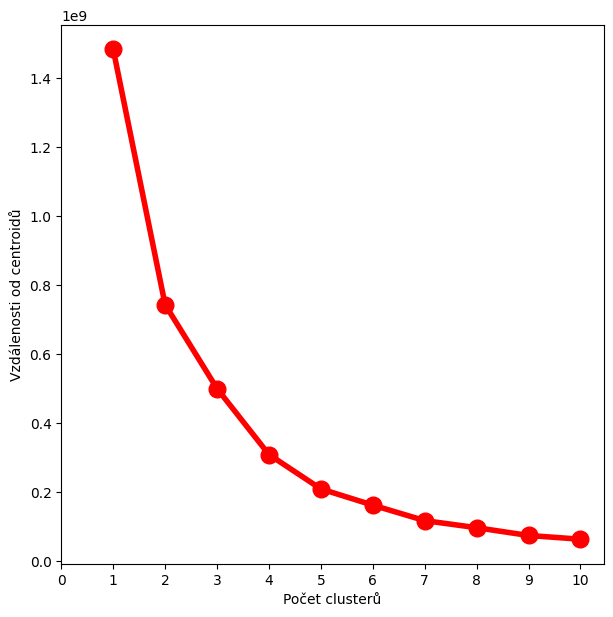

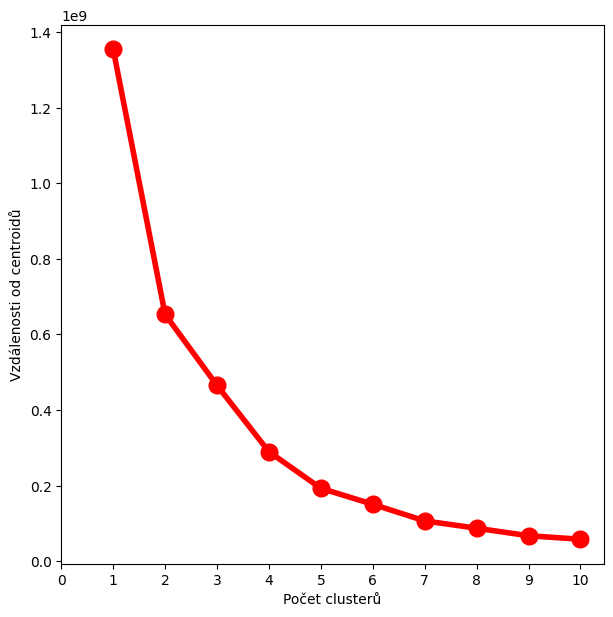

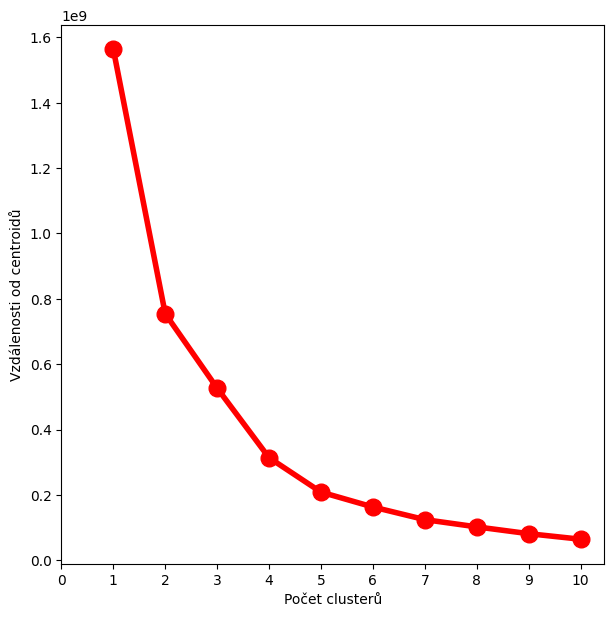

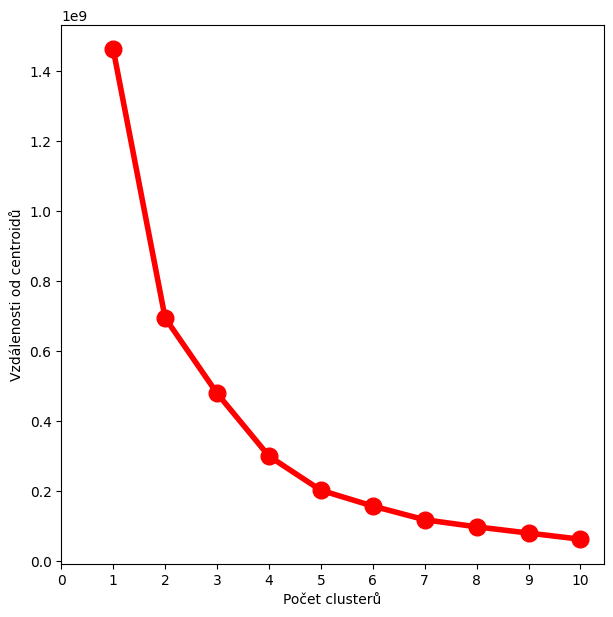

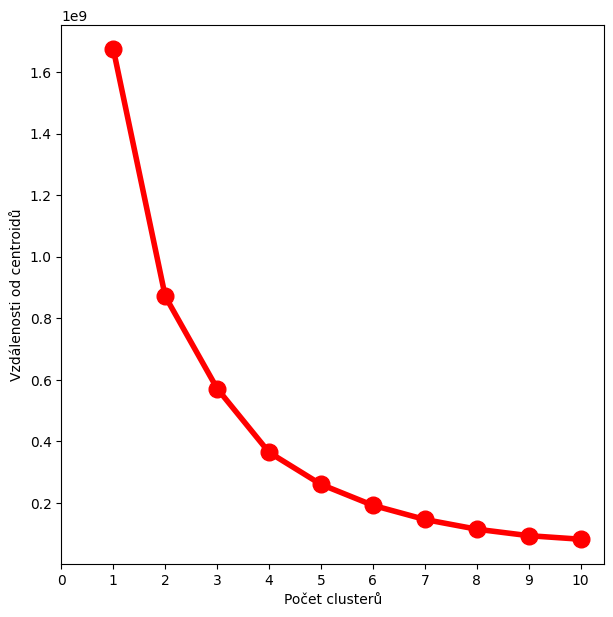

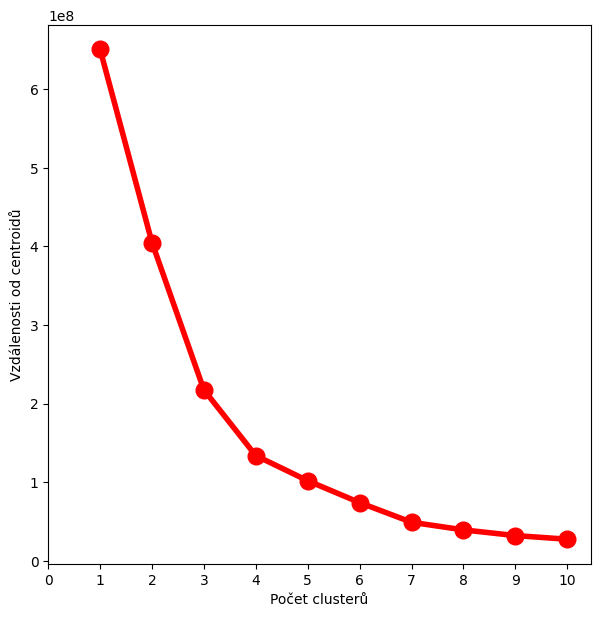

In [5]:
# https://www.kaggle.com/code/naren3256/kmeans-clustering-and-cluster-visualization-in-3d
# https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
# Vypocet K-means pro pocet clusteru 1-11.
# Podle vysledneho grafu se urci bod (pocet clusteru), za kterym uz se hodnoty prilis nezlepsuji
for i in range(len(datasets)):
    WCSS = []
    for j in range(1,11):
        model = KMeans(n_clusters = j, init = 'k-means++', n_init=5, max_iter=100, random_state=42)
        model.fit(datasets[i])
        WCSS.append(model.inertia_)
    fig = plt.figure(figsize = (7,7))
    plt.plot(range(1,11),WCSS, linewidth=4, markersize=12,marker='o',color = 'red')
    plt.xticks(numpy.arange(11))
    plt.xlabel("Počet clusterů")
    plt.ylabel("Vzdálenosti od centroidů")
    plt.show()

#### Optimální množství clusterů
- Množství clusterů bylo zvoleno na základě tzv. [*elbow*](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/) metody
- Z grafů výše vyplývá, že optimální množství clusterů bude 5 pro všechny datasety. Poté už zisky graficky neospraveddlňují overfitting.

### Výpočet K-means a vyhodnocení úspěšnosti

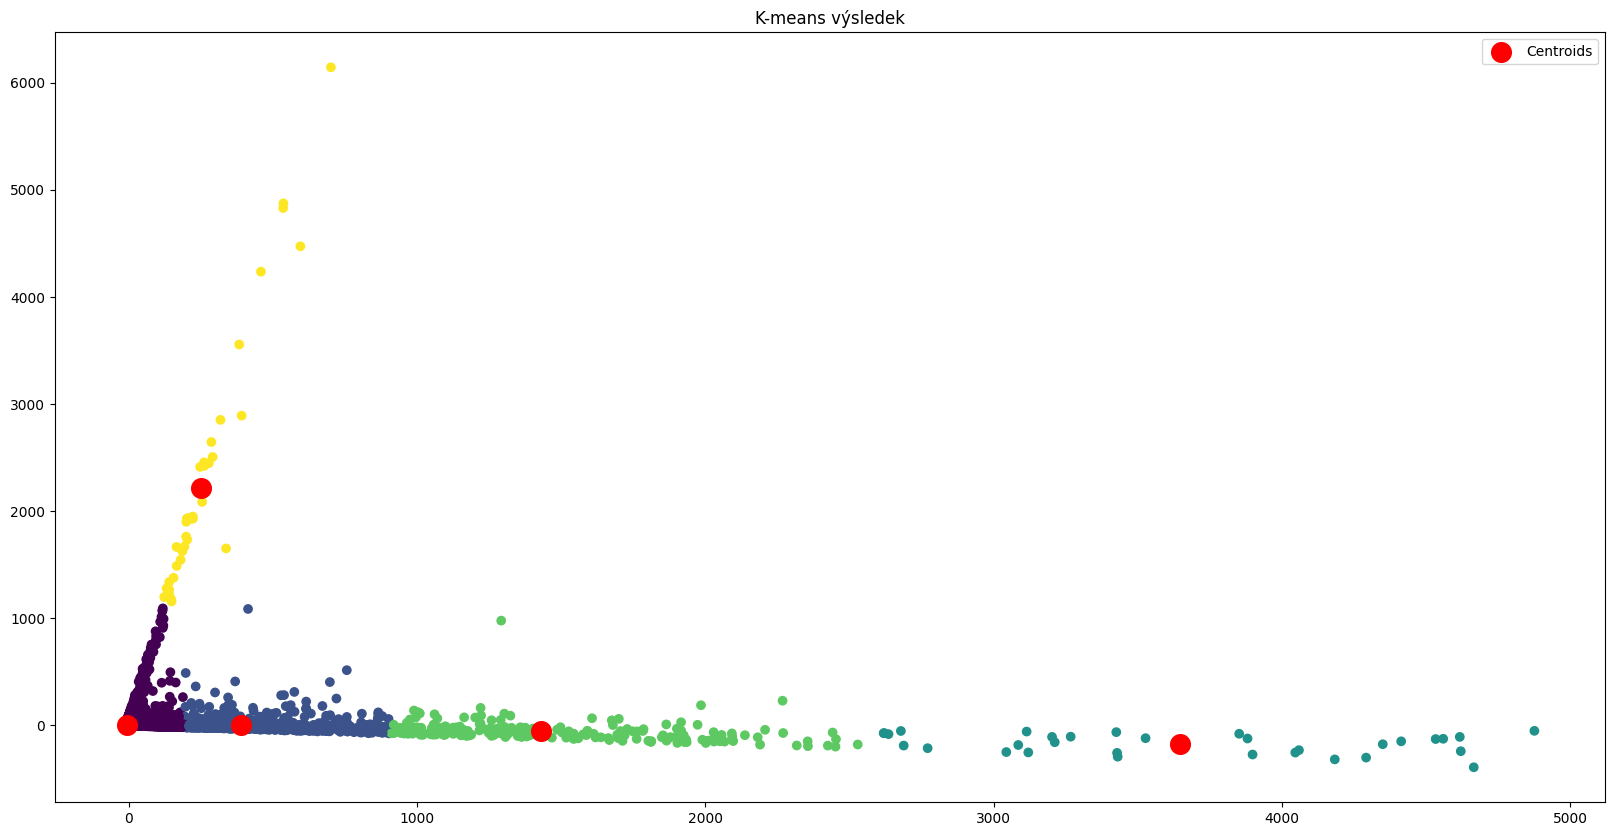

Davies-Bouldin index pro dataset 0: 0.45602747765348833


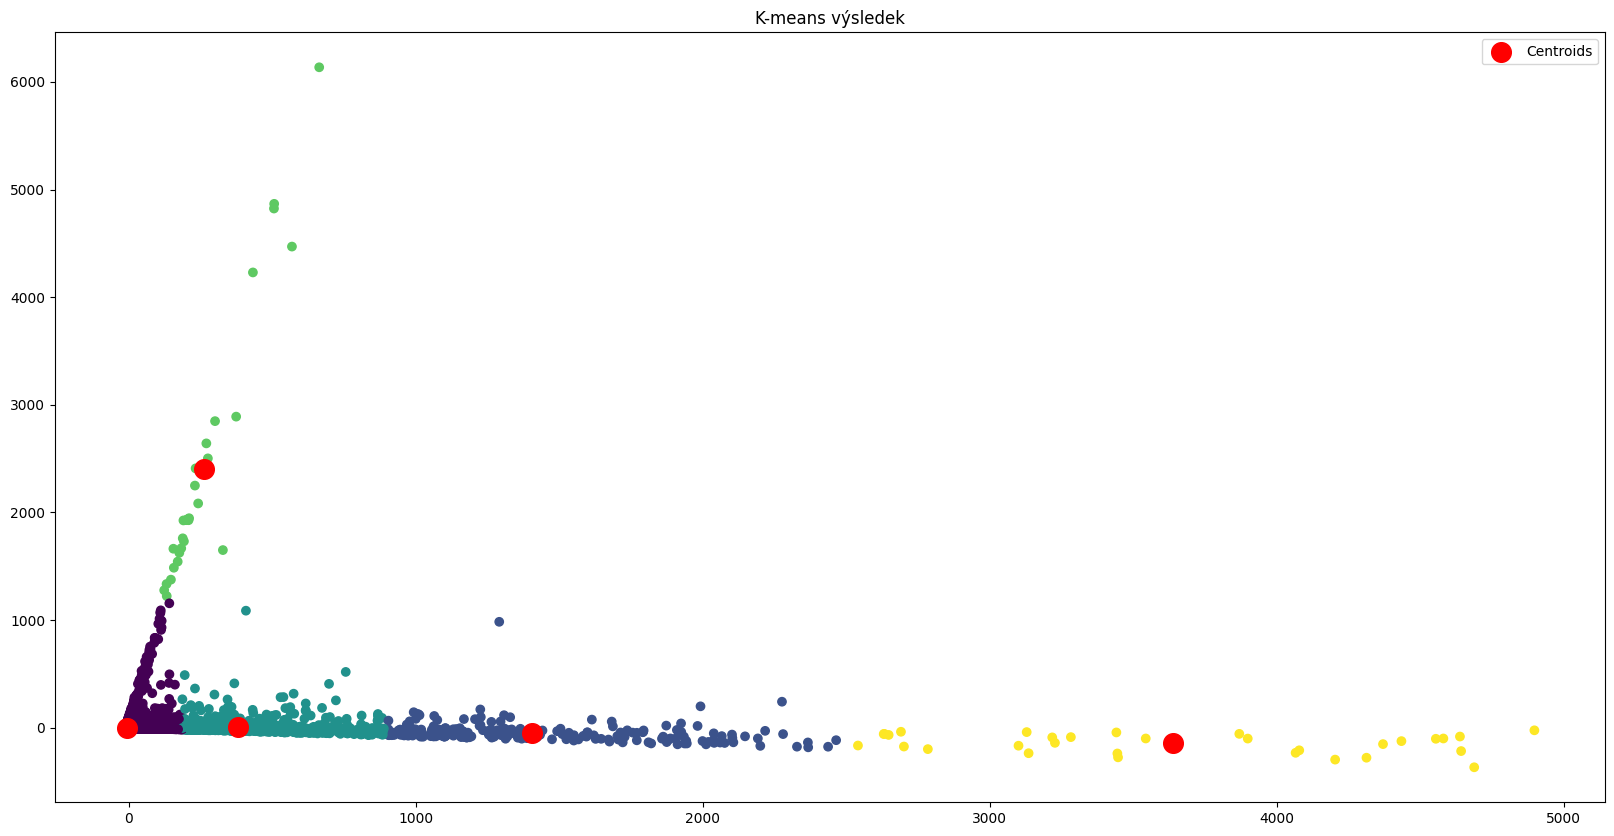

Davies-Bouldin index pro dataset 1: 0.4646481265345906


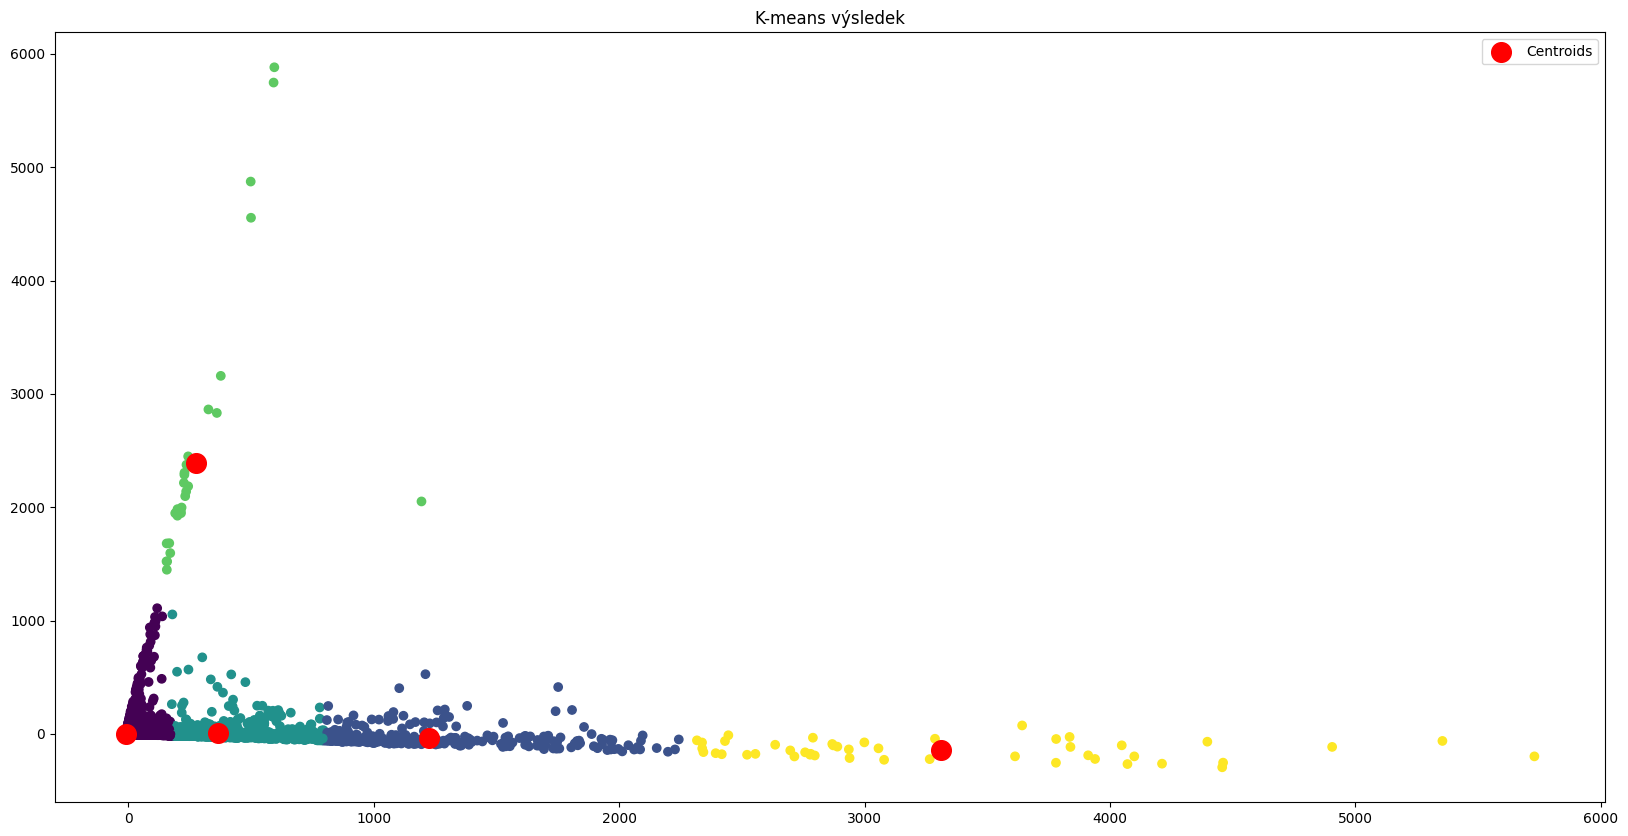

Davies-Bouldin index pro dataset 2: 0.4658732551641031


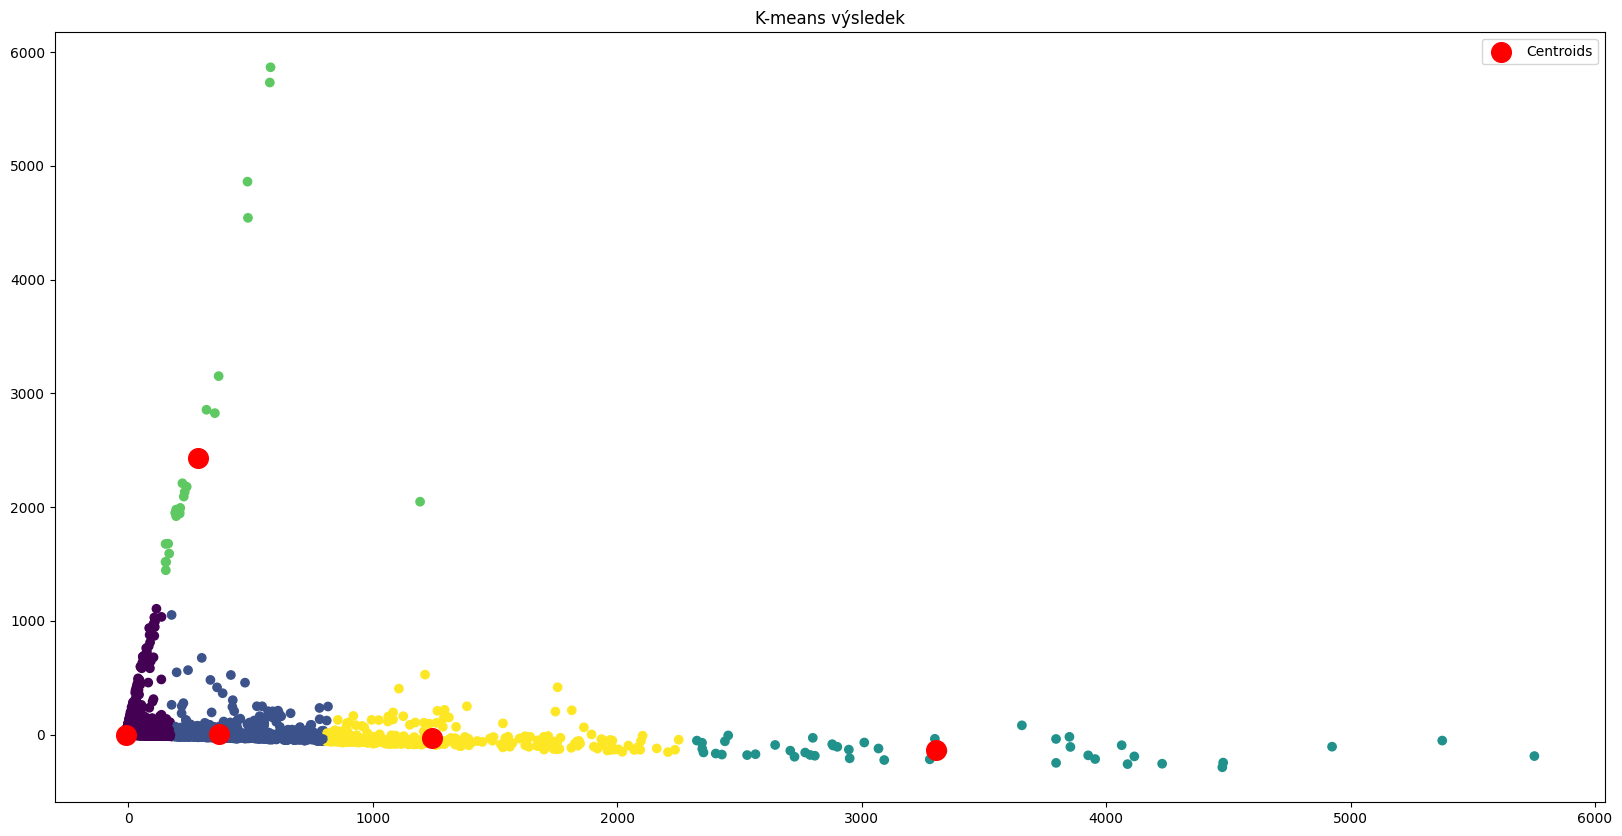

Davies-Bouldin index pro dataset 3: 0.47812374941093383


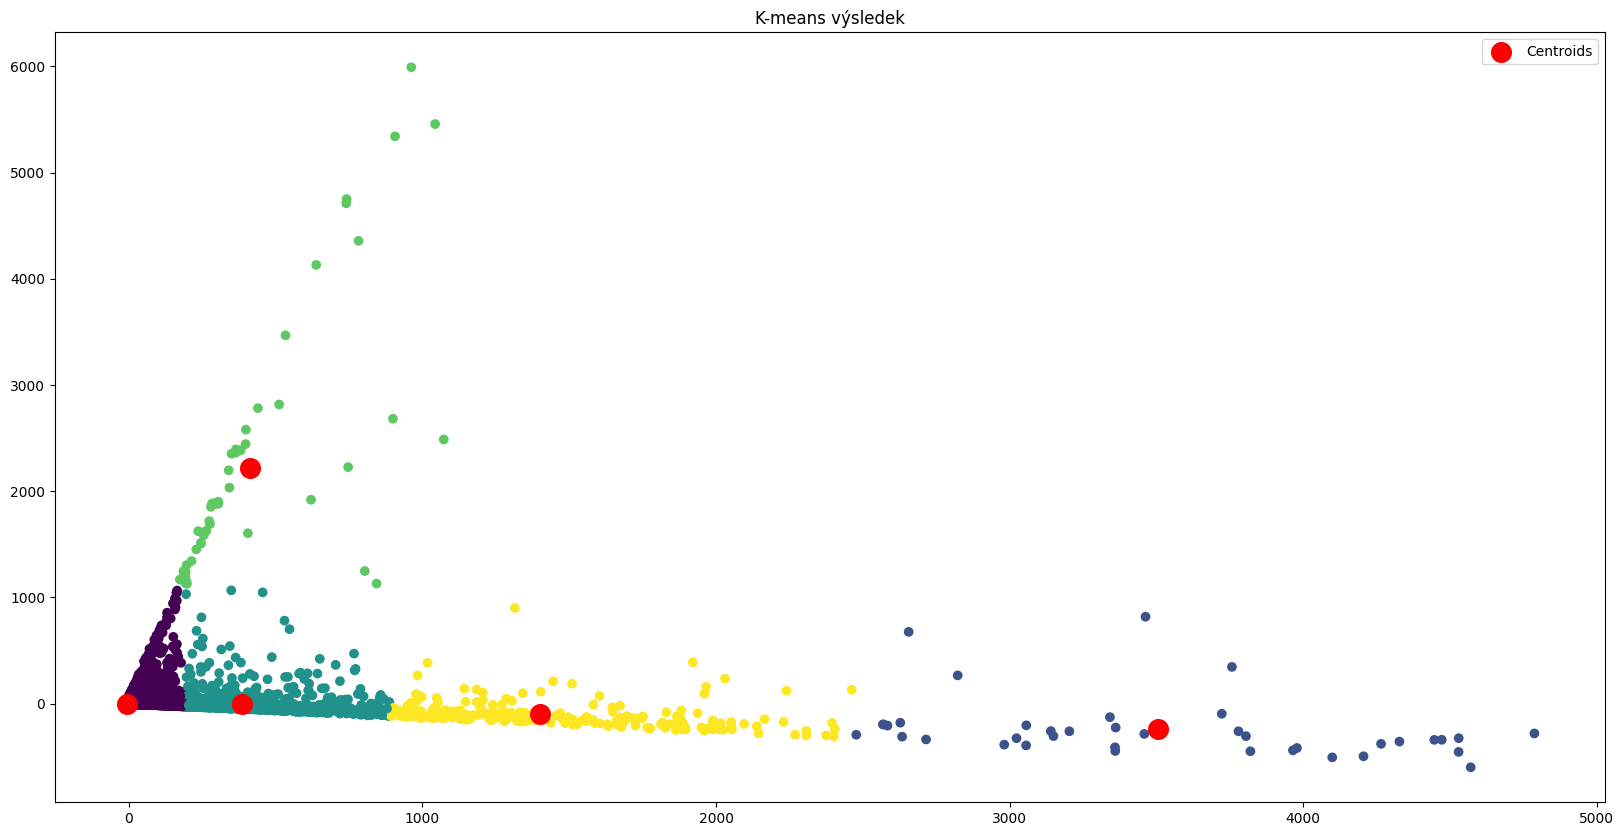

Davies-Bouldin index pro dataset 4: 0.48566748606709237


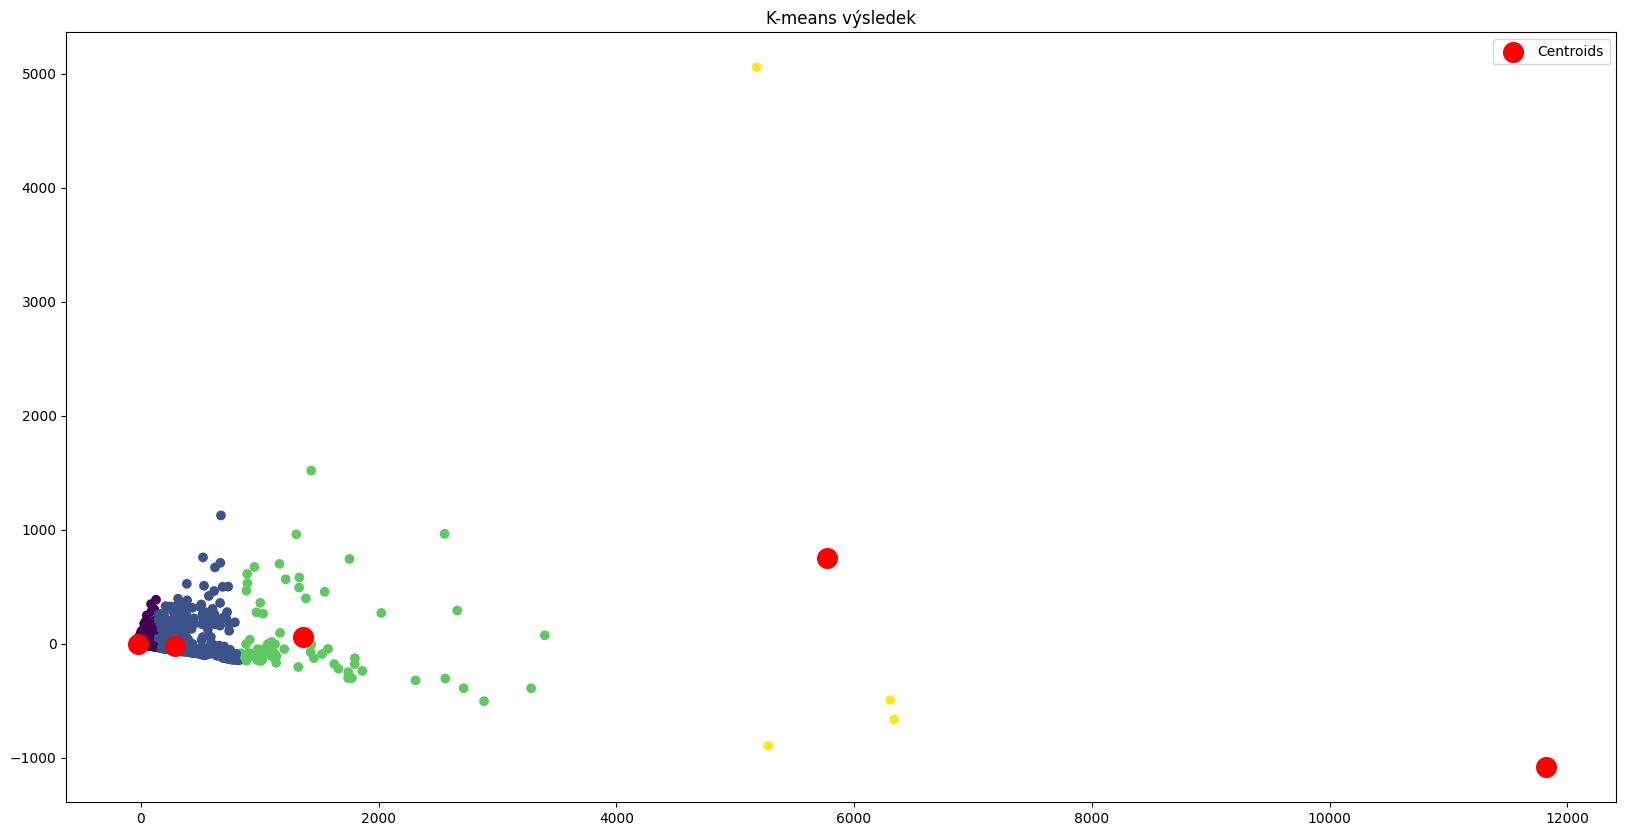

Davies-Bouldin index pro dataset 5: 0.5279182548060435


In [6]:
from sklearn.metrics import davies_bouldin_score

# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
for i in range(len(datasets)):
    kmeans = KMeans(init="k-means++", n_init=5, n_clusters=5, max_iter=100, random_state=42)
    kmeans.fit(datasets[i])
    
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    plt.figure(figsize = (20,10))
    plt.scatter(datasets[i][:, 0], datasets[i][:, 1], c=labels)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, label='Centroids')
    plt.title('K-means výsledek')
    plt.legend()
    plt.show()
    
    # Prirazeni 
    datasets_save[i]["CLUSTER"] = labels
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html
    # Cim blize je cislo k 0, tim kvalitnejsi clustery jsou
    dbi = davies_bouldin_score(datasets[i], kmeans.labels_)
    
    print("Davies-Bouldin index pro dataset " + str(i) + ":", dbi)

#### Výsledek K-means
- Vizualizace zobrazuje rozložení vzniklých 5 clusterů v prostoru pro každý dataset. Poslední vyobrazený je speciální Youtube dataset.
- Jako metrika úspěšnosti se použil Davies-Bouldin index. Čím blíže je index k 0, tím kvalitnější výsledky jsou. Hodnota *0.456* se ovšem za kvalitní označit nedá, ačkoliv je ze všech získaných nejlepší
- Nejlepší koeficieny (*0.456*) byl získány pro dataset 0 (detailnější popis viz začátek této [sekce](#datasets_explained)). Rozdíl oproti ostatním datasetům byl však poměrně nízký.
- Experimentálně byly odzkoušeny různé nastavení K-means, společně s používáním kombinací konkrétních sloupců. Žádný z výsledků ovšem nepůsobí optimisticky -- viz koeficienty pro jednotlivé datasety.
- Důvod nízké kvality clusterování mohou být i data samotná -- mohou v nich figurovat nezachycené anomálie, nebo mohlo dojít i k jiným, neobjeveným problémům. Celkově, jak lze vidět, jsou data velmi blízko -- navzájem se podobají.

### Vyhodnocení shluků
Další výsledky vychází již pouze z nejlepšího nastavení, tzn. pro dataset 0.
Pro jednotlivé nalezené shluky bude prozkoumáno 10 nejčastějších služeb a bude hledána podobnost mezi nimi.

Později se zaměříme i na výsledky ze speciálního Youtube datasetu.

#### Množství hodnot v clusterech

CLUSTER
0    124518
1      1021
3       217
4        49
2        32
Name: count, dtype: int64


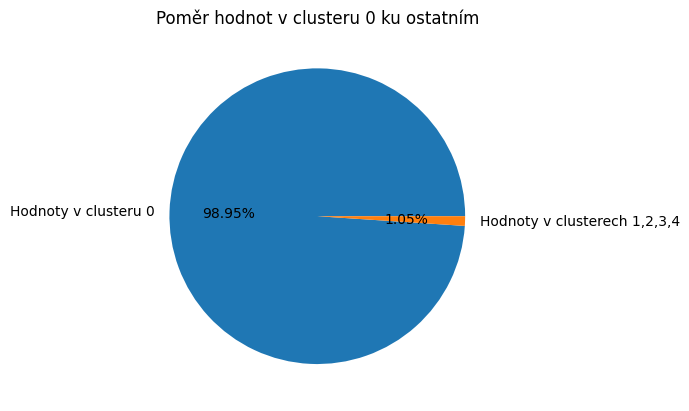

In [7]:
# Navrat puvodnich TLS_SNI hodnot pro dataset 0
df = datasets_save[0]
df["TLS_SNI"] = tls_labels[0]

print(df["CLUSTER"].value_counts())

n_of_zero_cl = df["CLUSTER"].value_counts().nlargest(1).sum()
rest = df["CLUSTER"].value_counts().sum() - n_of_zero_cl

fig, ax = plt.subplots()
ax.pie([n_of_zero_cl, rest], labels=["Hodnoty v clusteru 0", "Hodnoty v clusterech 1,2,3,4"], autopct='%1.2f%%');
ax.set_title("Poměr hodnot v clusteru 0 ku ostatním");

- Většina hodnot (*98.95%*) je v clusteru 0
- Z důvodu takto jednostranného rozdělení se výsledky K-means nedají označit za kvalitní.

Dále se zaměříme na hodnoty v jednotlivých clusterech -- co mají společné.

In [8]:
cluster_counts_tls = df.groupby("CLUSTER")["TLS_SNI"].value_counts()
cluster_counts_tls.groupby("CLUSTER").nlargest(10)

CLUSTER  CLUSTER  TLS_SNI                                 
0        0        www.google.com                              7254
                  dns.google                                  3020
                  doh.opendns.com                             2870
                  fonts.gstatic.com                           2864
                  play.googleapis.com                         2430
                  googleads.g.doubleclick.net                 2256
                  safebrowsing.googleapis.com                 2240
                  www.youtube.com                             2155
                  www.googleapis.com                          2106
                  geller-pa.googleapis.com                    2093
1        1        www.google.com                               121
                  r5---sn-2gb7snez.c.2mdn.net                   96
                  www.youtube.com                               87
                  mail.google.com                               49
   

- Z výčtu jednotlivých názvů serverů je patrné, že stejné adresy se vyskytují ve více clusterech. 
- Jak zmiňuje zadání, je možné, že služby jako www.youtube.com mají více různých toků (metadata, video...)
- Zároveň jsou clustery rozdělené podle typu služby -- jak lze vidět v clusteru 1, 2 a 3, jsou v něm primárně videoslužby, ze kterých se stahovala data.
- Výsledků v daném clusteru je však natolik málo, že není možné jednoznačně říct, že se nejedná o chybu.

<a id="youtube-k-means"></a>
### Youtube dataset

Ještě jednou si jej vizualizujeme.

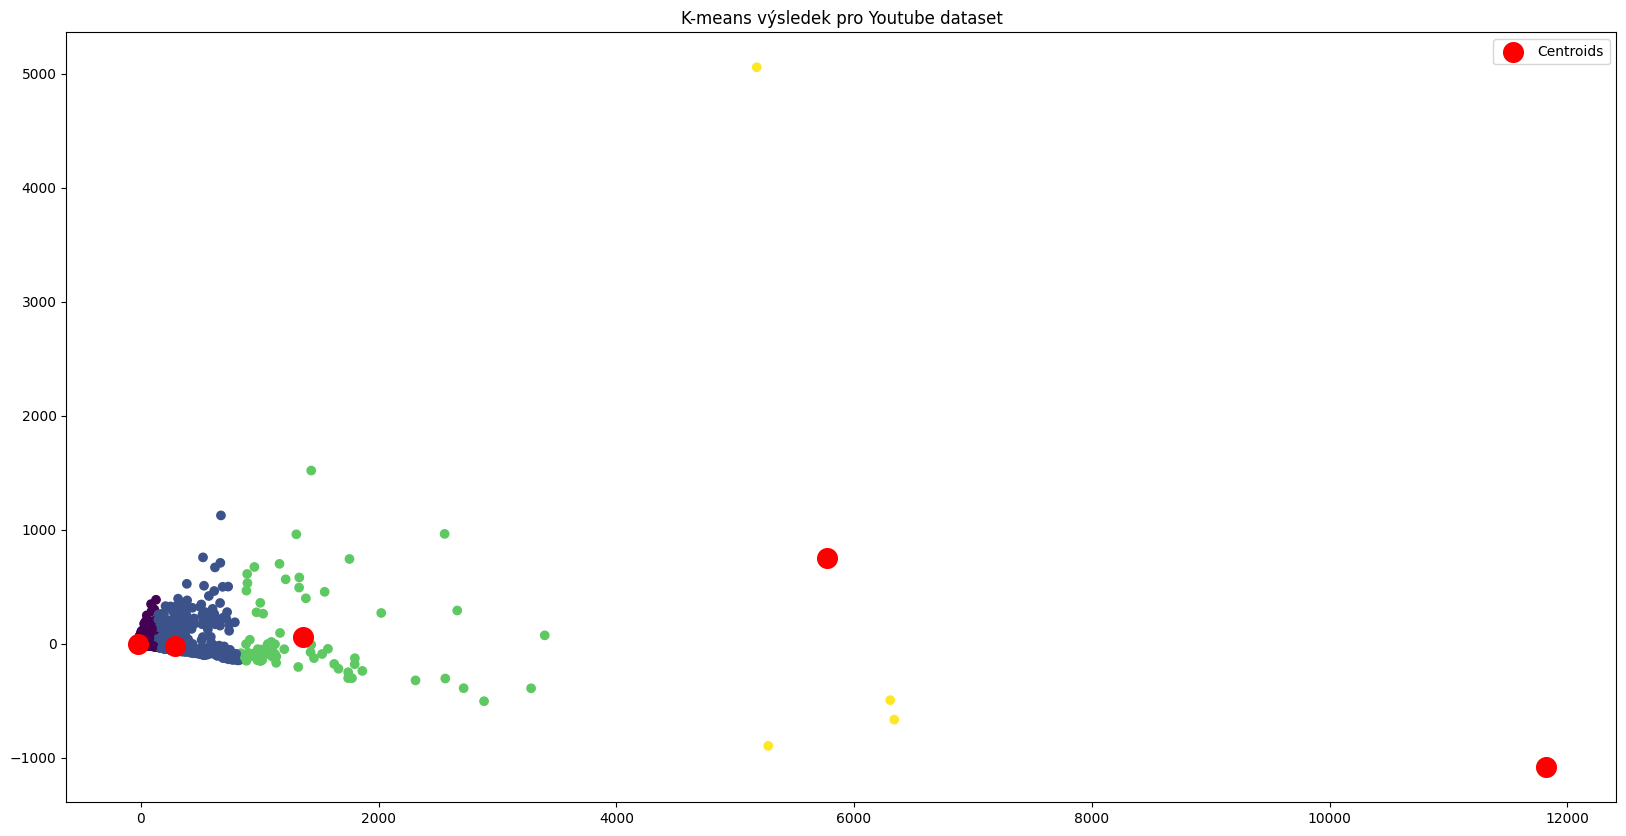

CLUSTER
0    21189
1     1460
3       74
4        4
2        1
Name: count, dtype: int64


In [9]:
df_k = datasets_save[5]

kmeans = KMeans(init="k-means++", n_init=5, n_clusters=5, max_iter=100, random_state=42)
kmeans.fit(datasets[5])
    
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
    
plt.figure(figsize = (20,10))
plt.scatter(datasets[5][:, 0], datasets[5][:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, label='Centroids')
plt.title('K-means výsledek pro Youtube dataset')
plt.legend()
plt.show()

# Nactu si hodnoty z puvodniho datasetu, ale pouze ty odpovidajici tokum s Youtube
df_k = original_df[original_df.index.isin(df_k.index)].copy(deep=True)

# Priradim ziskane clustery
df_k["CLUSTER"] = labels

print(df_k["CLUSTER"].value_counts())
cluster_counts_tls = df_k.groupby("CLUSTER").value_counts()


Výsledky jsou oproti ostatním datasetům zajímavé v tom, že cluster 1 obsahuje 1460 hodnot -- to je o mnoho víc než ostatní datasety.

Clustery 4 a 2 jsou se svými 6 hodnotami zanedbatelné. Zaměříme se primárně na clustery 0,1,3.
Nejprve si spočítáme počet paketů a počet přenesených bytů v tocích. Dále se zaměříme ne průměrný čas toku.



In [10]:
def print_cluster_stats(df):
    # prumerny pocet odeslanych paketu v tocich v jednotlivych clusterech
    mean_packets = df.groupby("CLUSTER")["PACKETS"].mean().sort_values()
    print("Prumerny pocet paketu klient->server\n", mean_packets)
    
    # prumerny pocet stazenych paketu v tocich v jednotlivych clusterech
    mean_packets_back = df.groupby("CLUSTER")["PACKETS_REV"].mean().sort_values()
    print("Prumerny pocet paketu server->klient\n", mean_packets_back)
    
    # prumerny pocet odeslanych bytu v tocich v jednotlivych clusterech
    mean_bytes = df.groupby("CLUSTER")["BYTES"].mean().sort_values()
    print("Prumerna velikost toku v bytechve smeru  klient->server\n", mean_bytes)
    
    # prumerny pocet stazenych bytu v tocich v jednotlivych clusterech
    mean_bytes_back = df.groupby("CLUSTER")["BYTES_REV"].mean().sort_values()
    print("Prumerna velikost toku v bytech ve smeru server->klient\n", mean_bytes_back)
    
    df["TIME"] = (df["TIME_LAST"] - df["TIME_FIRST"]).astype("int64") // 1e6
    # prumerna delka toku v clusterech
    mean_time = df.groupby("CLUSTER")["TIME"].mean().sort_values()
    print("Prumerna delka trvani toku v sekundach\n", mean_time)

    return [mean_packets, mean_packets_back, mean_bytes, mean_bytes_back, mean_time]

df_k = df_k[df_k["CLUSTER"].isin([0, 1, 3])]
df_stats = print_cluster_stats(df_k)


Prumerny pocet paketu klient->server
 CLUSTER
0      27.029732
1     388.200000
3    2280.864865
Name: PACKETS, dtype: float64
Prumerny pocet paketu server->klient
 CLUSTER
0      34.488744
1     957.699315
3    4957.662162
Name: PACKETS_REV, dtype: float64
Prumerna velikost toku v bytechve smeru  klient->server
 CLUSTER
0      8704.201472
1     94598.794521
3    893329.486486
Name: BYTES, dtype: float64
Prumerna velikost toku v bytech ve smeru server->klient
 CLUSTER
0    1.969443e+04
1    1.134440e+06
3    4.865530e+06
Name: BYTES_REV, dtype: float64
Prumerna delka trvani toku v sekundach
 CLUSTER
0     29.398697
1    148.215068
3    793.729730
Name: TIME, dtype: float64


### Vyhodnocení Youtube datasetu
Ačkoliv byl DB Index pro Youtube dataset **0.53**, když porovnáme jednotlivé clustery, měřené hodnoty se liší, což je možné zvolit jako důkaz toho, že jednotlivé toky se serverem youtube.com se opravdu liší.

- Průměrný počet nahraných i stažených paketů i bytů je v clusteru 0 o mnoho nižší než v ostatních dvou.
- Průměrná délka toku je v clusteru 0 pouze 29 vteřin, zatímco v clusteru 1 to jsou skoro 2 a půl minuty a v clusteru 3 rovnou 13 minut 14 vteřin

<a id="k-means-youtube"></a>
## Hierarchické shlukování
Tato sekce je zaměřena na druhou metodu clusterování, která bude v notebooku popsána. Jedná se o hierarchické clusterování. Prováděno bude se stejnými datasety, se kterými pracoval i K-Means algoritmus.

Jelikož je proces velmi náročný, je nutné ještě dále snížit množství hodnot v datasetu (opět /10) a znovu provést PCA.

In [11]:
import copy
# https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html#sphx-glr-auto-examples-decomposition-plot-pca-iris-py

# Redukce poctu dimenzi na 2 -- v pripade 3 jsou o trosku horsi vysledky (ale podobne) -- experimentalne overeno
datasets = datasets_save
shorter_tls_labels = []

for i in range(len(datasets)-1): # Youtube dataset nezmensuju
    datasets[i]["TLS_SNI"] = tls_labels[i]
    # Z uz zkraceneho datasetu vezmu nahodne jen desetinu hodnot - jinak trvaji operace moc dlouho
    sample_size = int(datasets[i].shape[0] / 10)
    datasets[i] = datasets[i].sample(n=sample_size, random_state=42)

    # Odstraneni TLS_SNI, ktere jakozto ciste string hodnoty nebudou fungovat s PCA
    shorter_tls_labels.append(datasets[i]["TLS_SNI"])
    datasets[i] = datasets[i].drop(["TLS_SNI"], axis=1)

df_pcas  = []
datasets_save = []
for i in range(len(datasets)):
    datasets_save.append(copy.deepcopy(datasets[i]))
    pca = decomposition.PCA(n_components=2)
    pca = pca.fit(datasets[i])
    df_pca = pca.transform(datasets[i])
    df_pcas.append(df_pca)
datasets = df_pcas

Davies-Bouldin index pro dataset 0 a metodu ward: 0.3525986855202629
Davies-Bouldin index pro dataset 0 a metodu complete: 0.30785953396850163
Davies-Bouldin index pro dataset 0 a metodu average: 0.15796560436211327
Davies-Bouldin index pro dataset 0 a metodu single: 0.09616175443986318


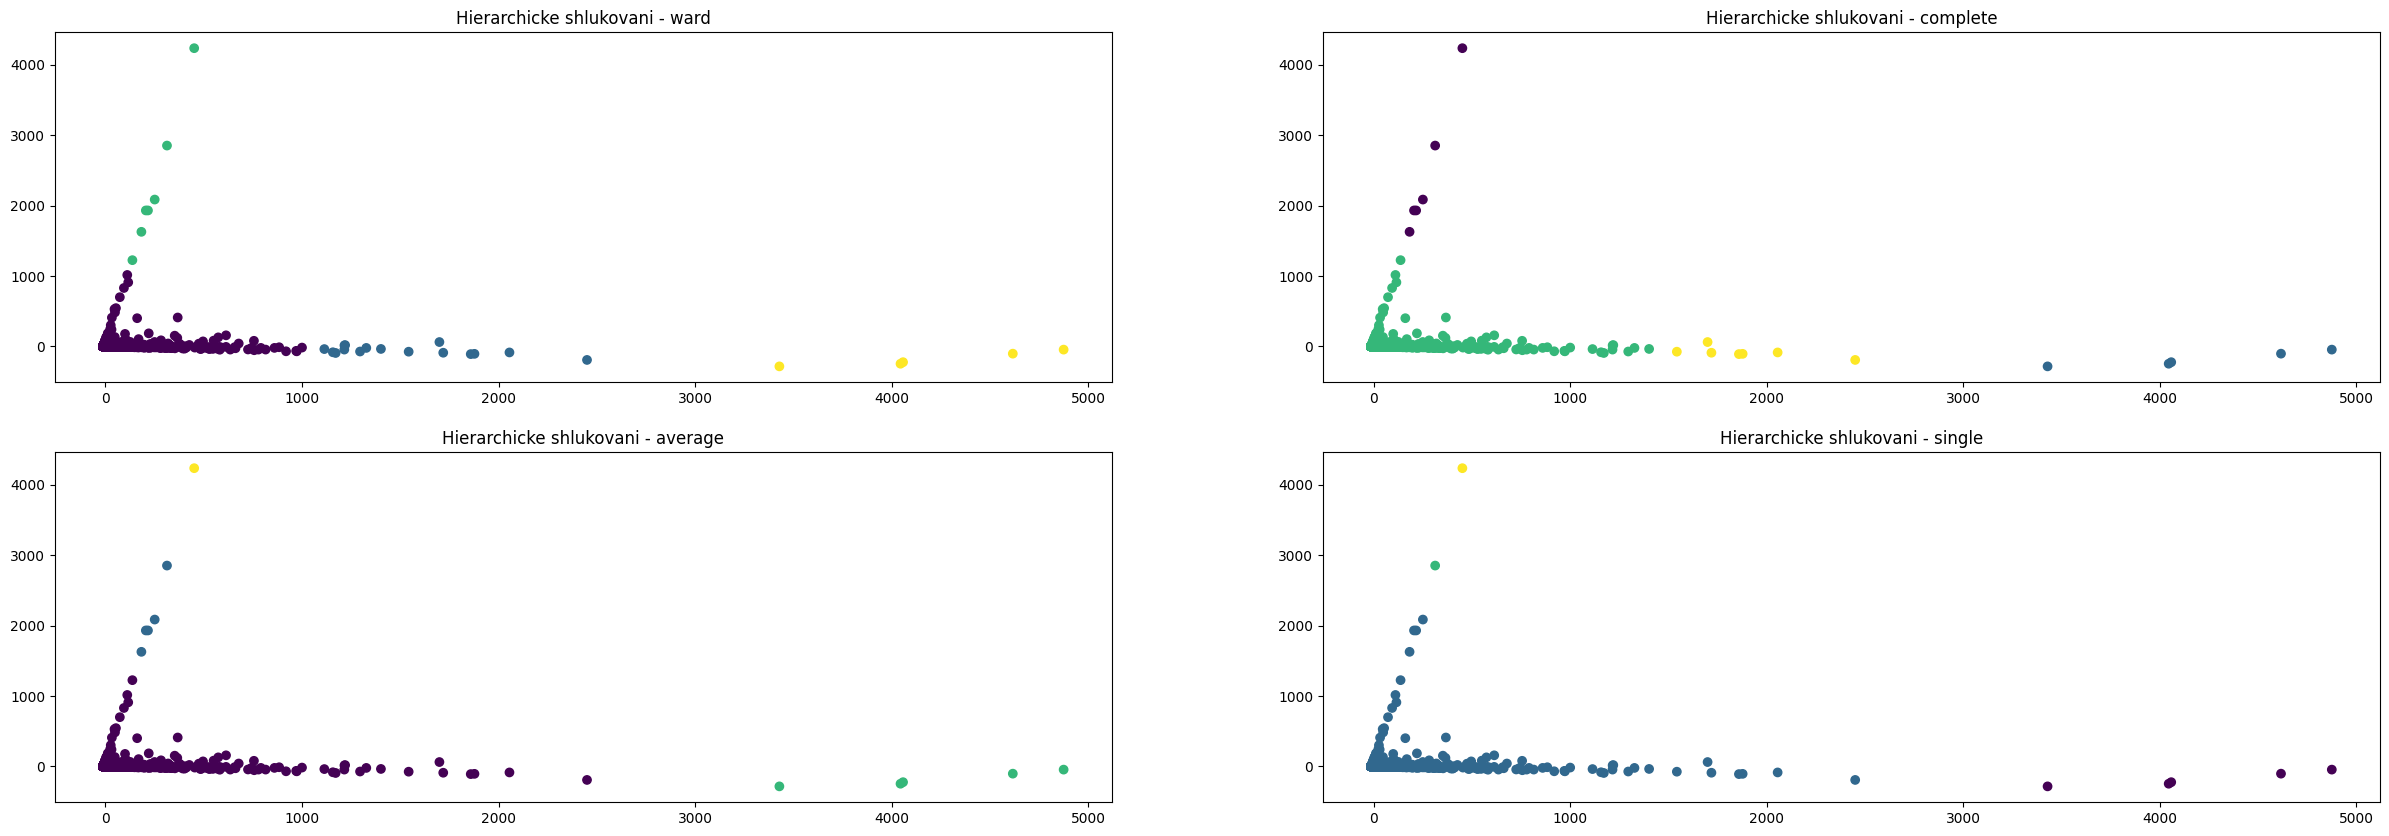

Davies-Bouldin index pro dataset 1 a metodu ward: 0.553062560248135
Davies-Bouldin index pro dataset 1 a metodu complete: 0.20204542026430353
Davies-Bouldin index pro dataset 1 a metodu average: 0.30895779160446296
Davies-Bouldin index pro dataset 1 a metodu single: 0.006659006657478233


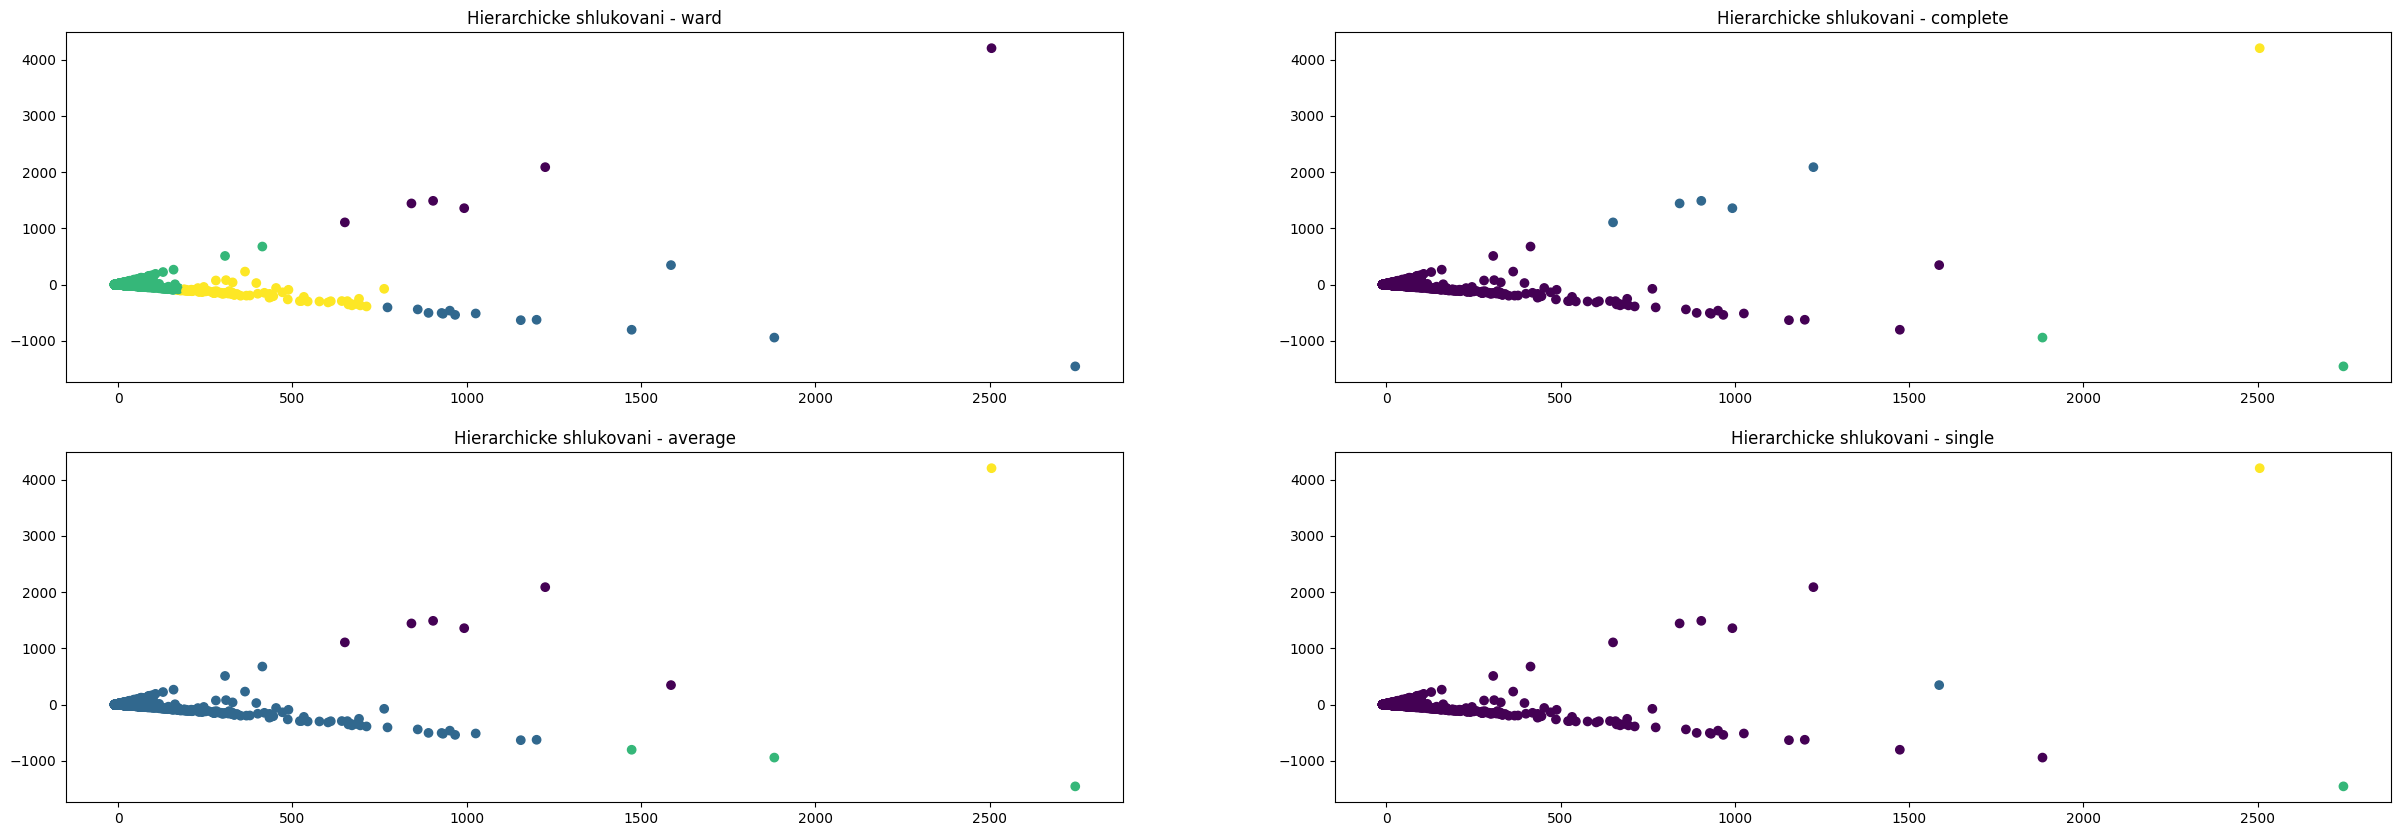

Davies-Bouldin index pro dataset 2 a metodu ward: 0.35026379715444383
Davies-Bouldin index pro dataset 2 a metodu complete: 0.14039475717413025
Davies-Bouldin index pro dataset 2 a metodu average: 0.14039475717413027
Davies-Bouldin index pro dataset 2 a metodu single: 0.051509639577325905


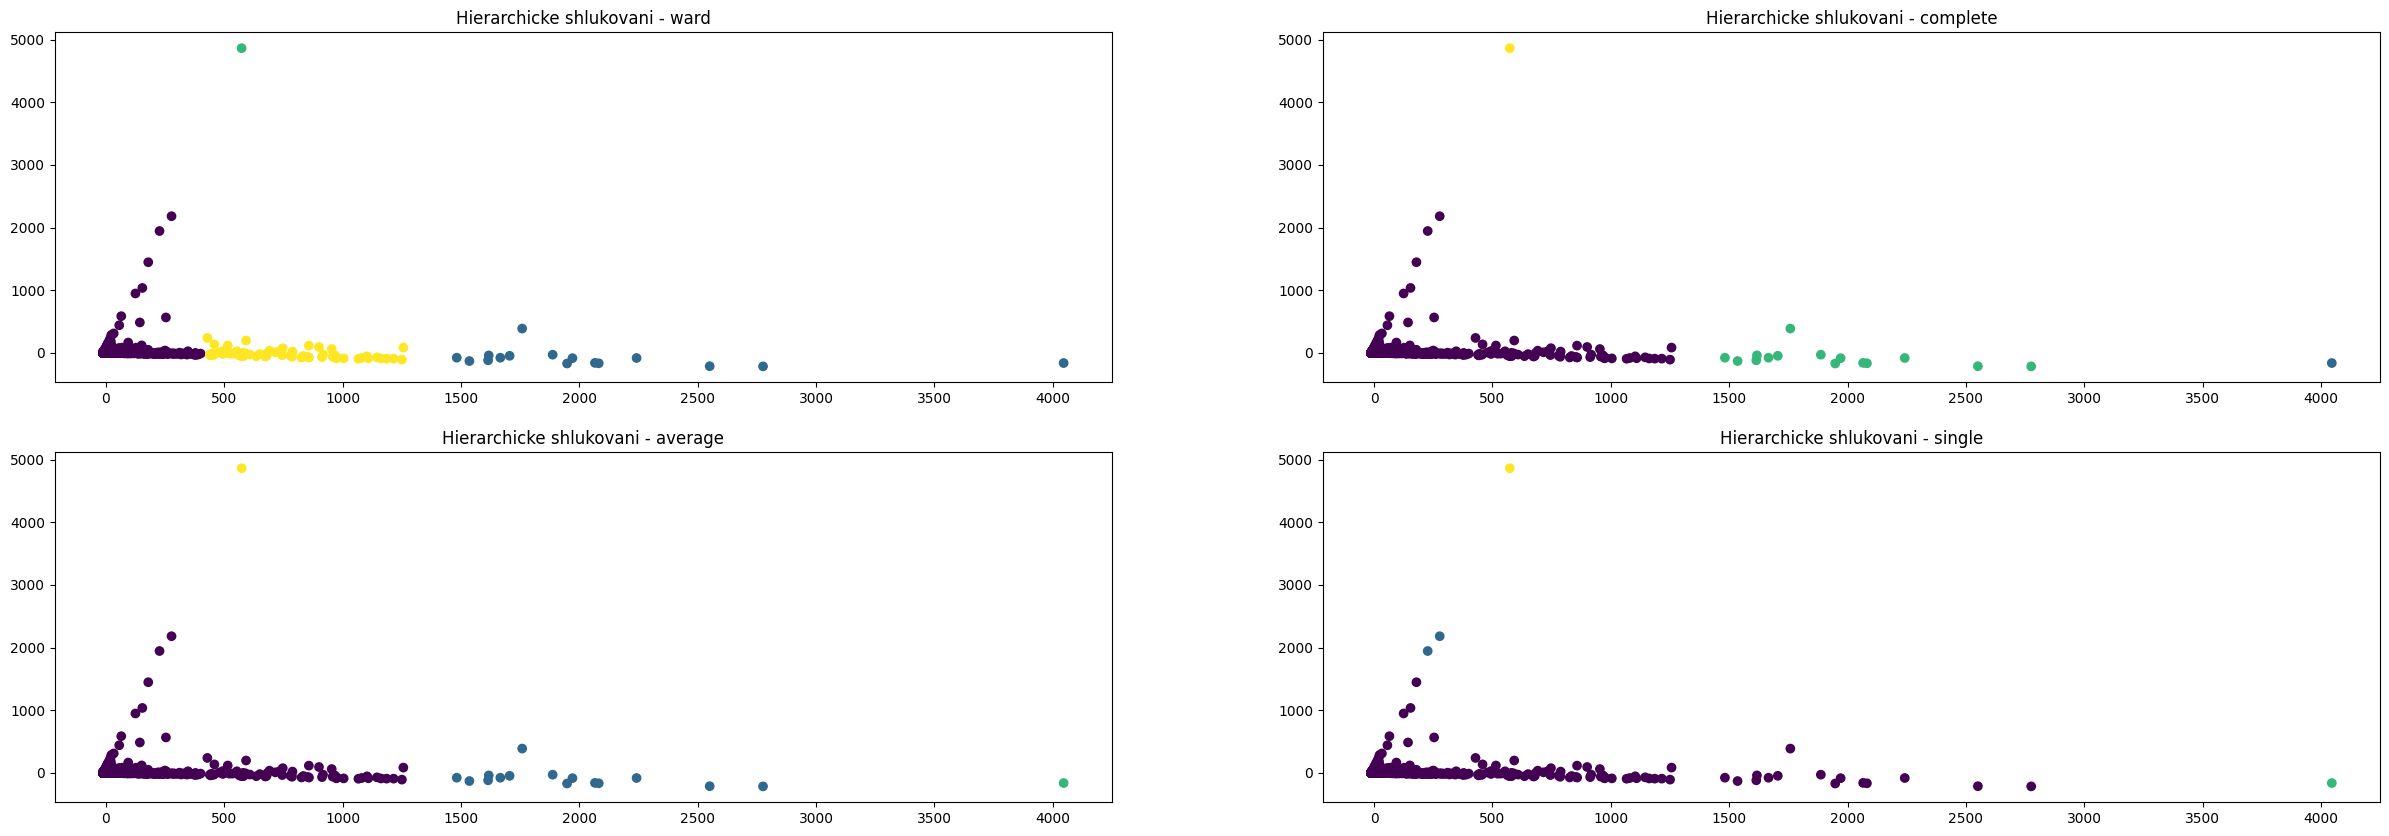

Davies-Bouldin index pro dataset 3 a metodu ward: 0.43143923815557417
Davies-Bouldin index pro dataset 3 a metodu complete: 0.2098872565406357
Davies-Bouldin index pro dataset 3 a metodu average: 0.24074629080547766
Davies-Bouldin index pro dataset 3 a metodu single: 0.09165367888947912


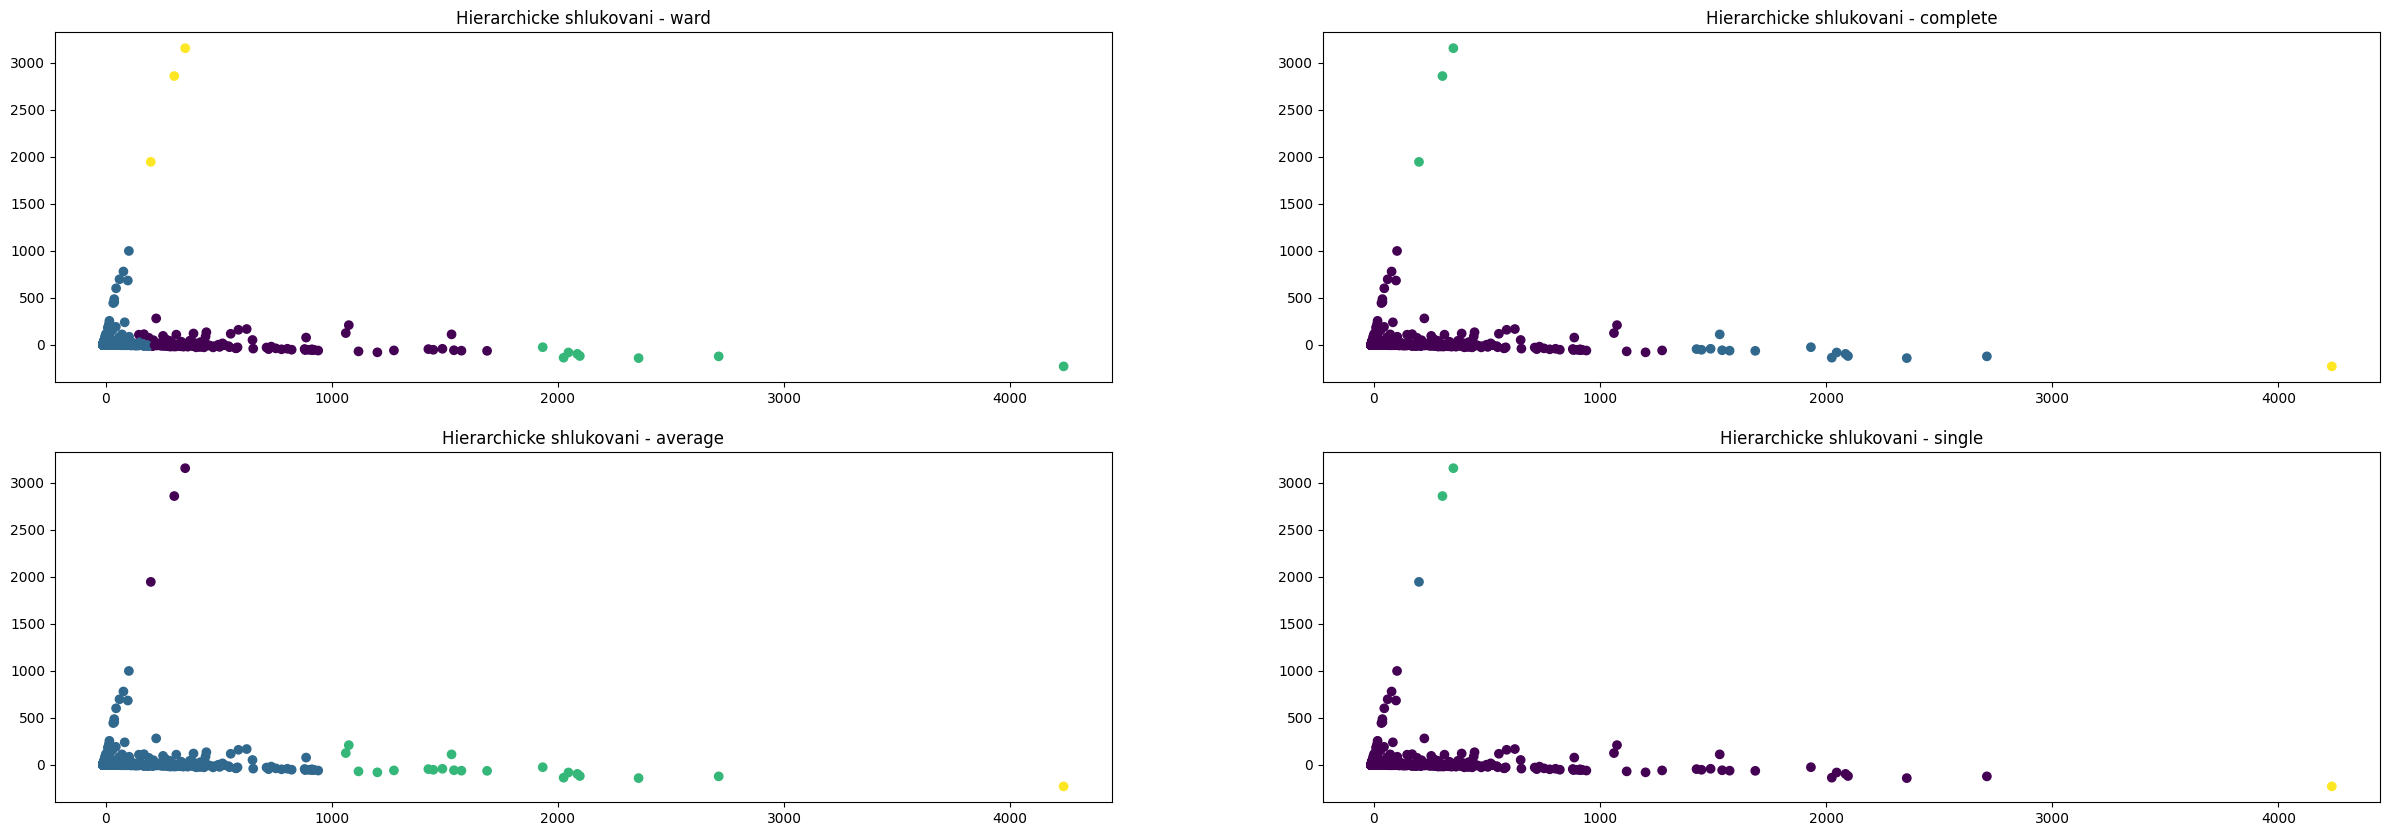

Davies-Bouldin index pro dataset 4 a metodu ward: 0.5605429087249907
Davies-Bouldin index pro dataset 4 a metodu complete: 0.24617666204269617
Davies-Bouldin index pro dataset 4 a metodu average: 0.24617666204269617
Davies-Bouldin index pro dataset 4 a metodu single: 0.1545669856358482


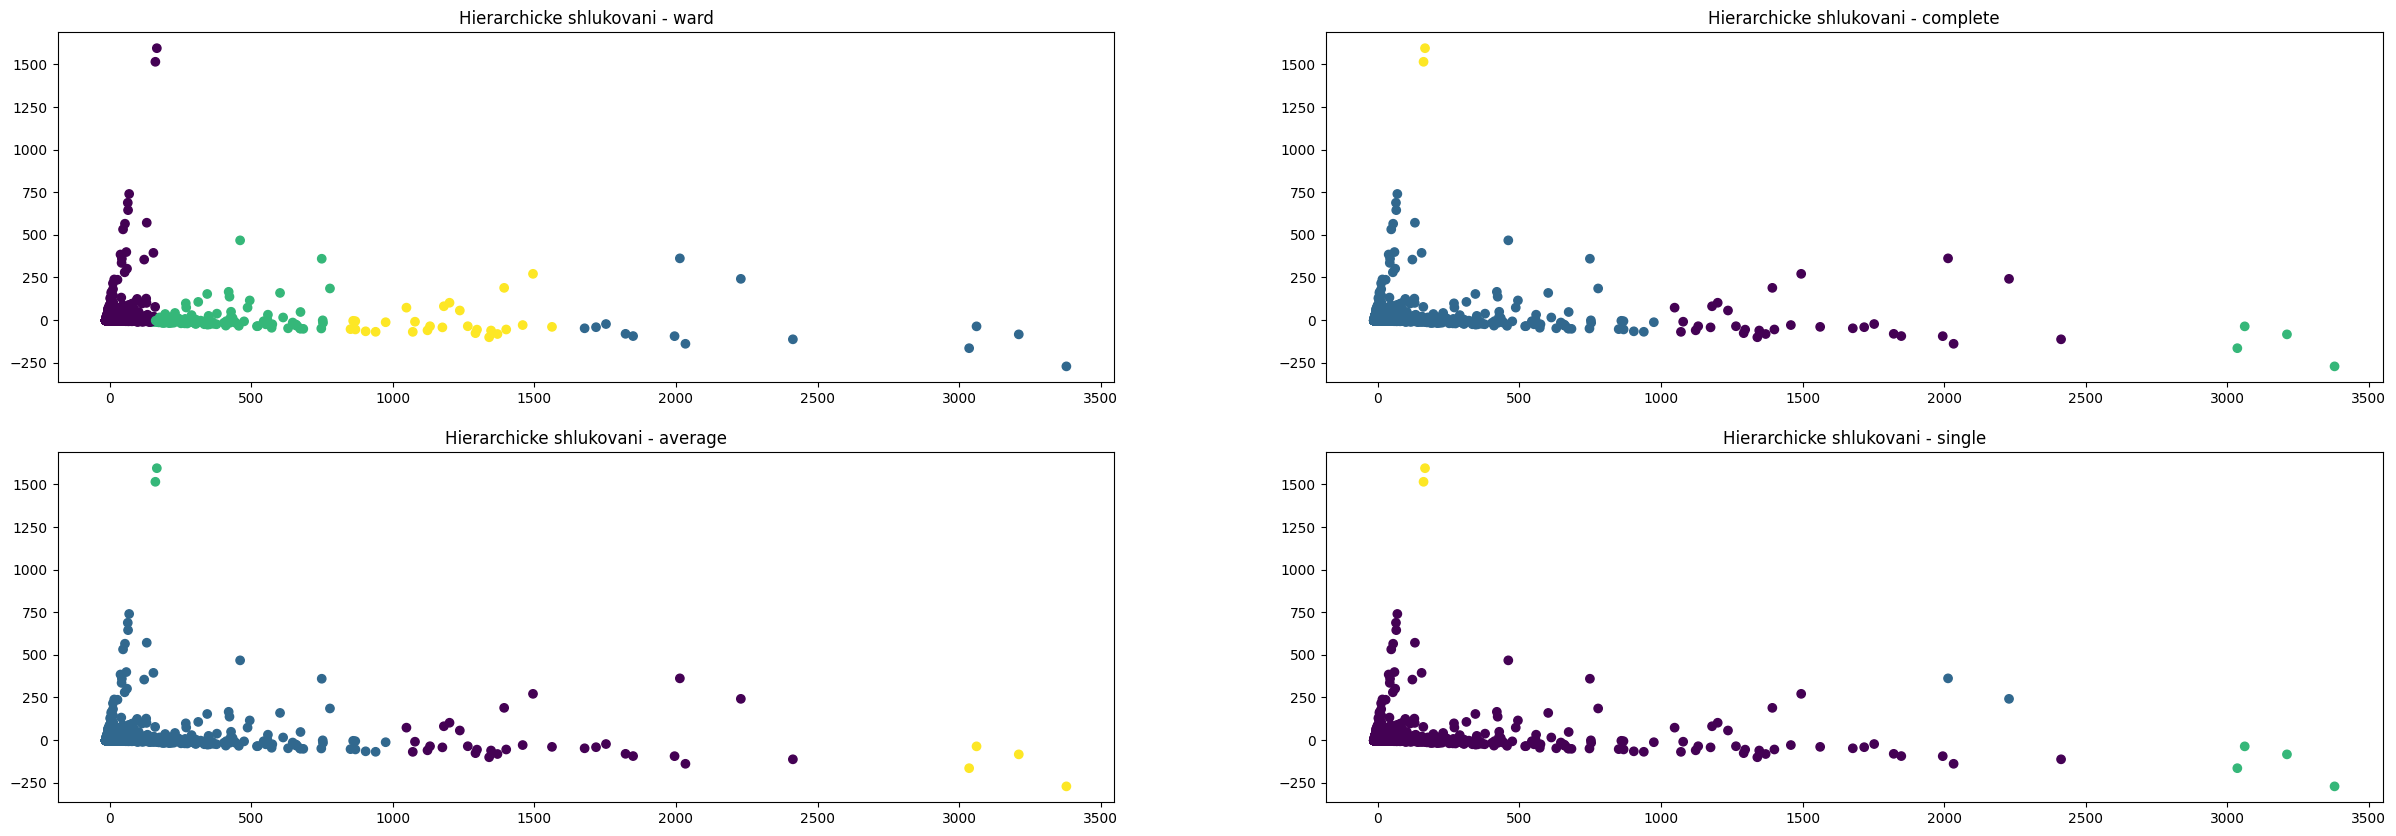

Davies-Bouldin index pro dataset 5 a metodu ward: 0.6227810363807387
Davies-Bouldin index pro dataset 5 a metodu complete: 0.08712465462179986
Davies-Bouldin index pro dataset 5 a metodu average: 0.08712465462179986
Davies-Bouldin index pro dataset 5 a metodu single: 0.08712465462179986


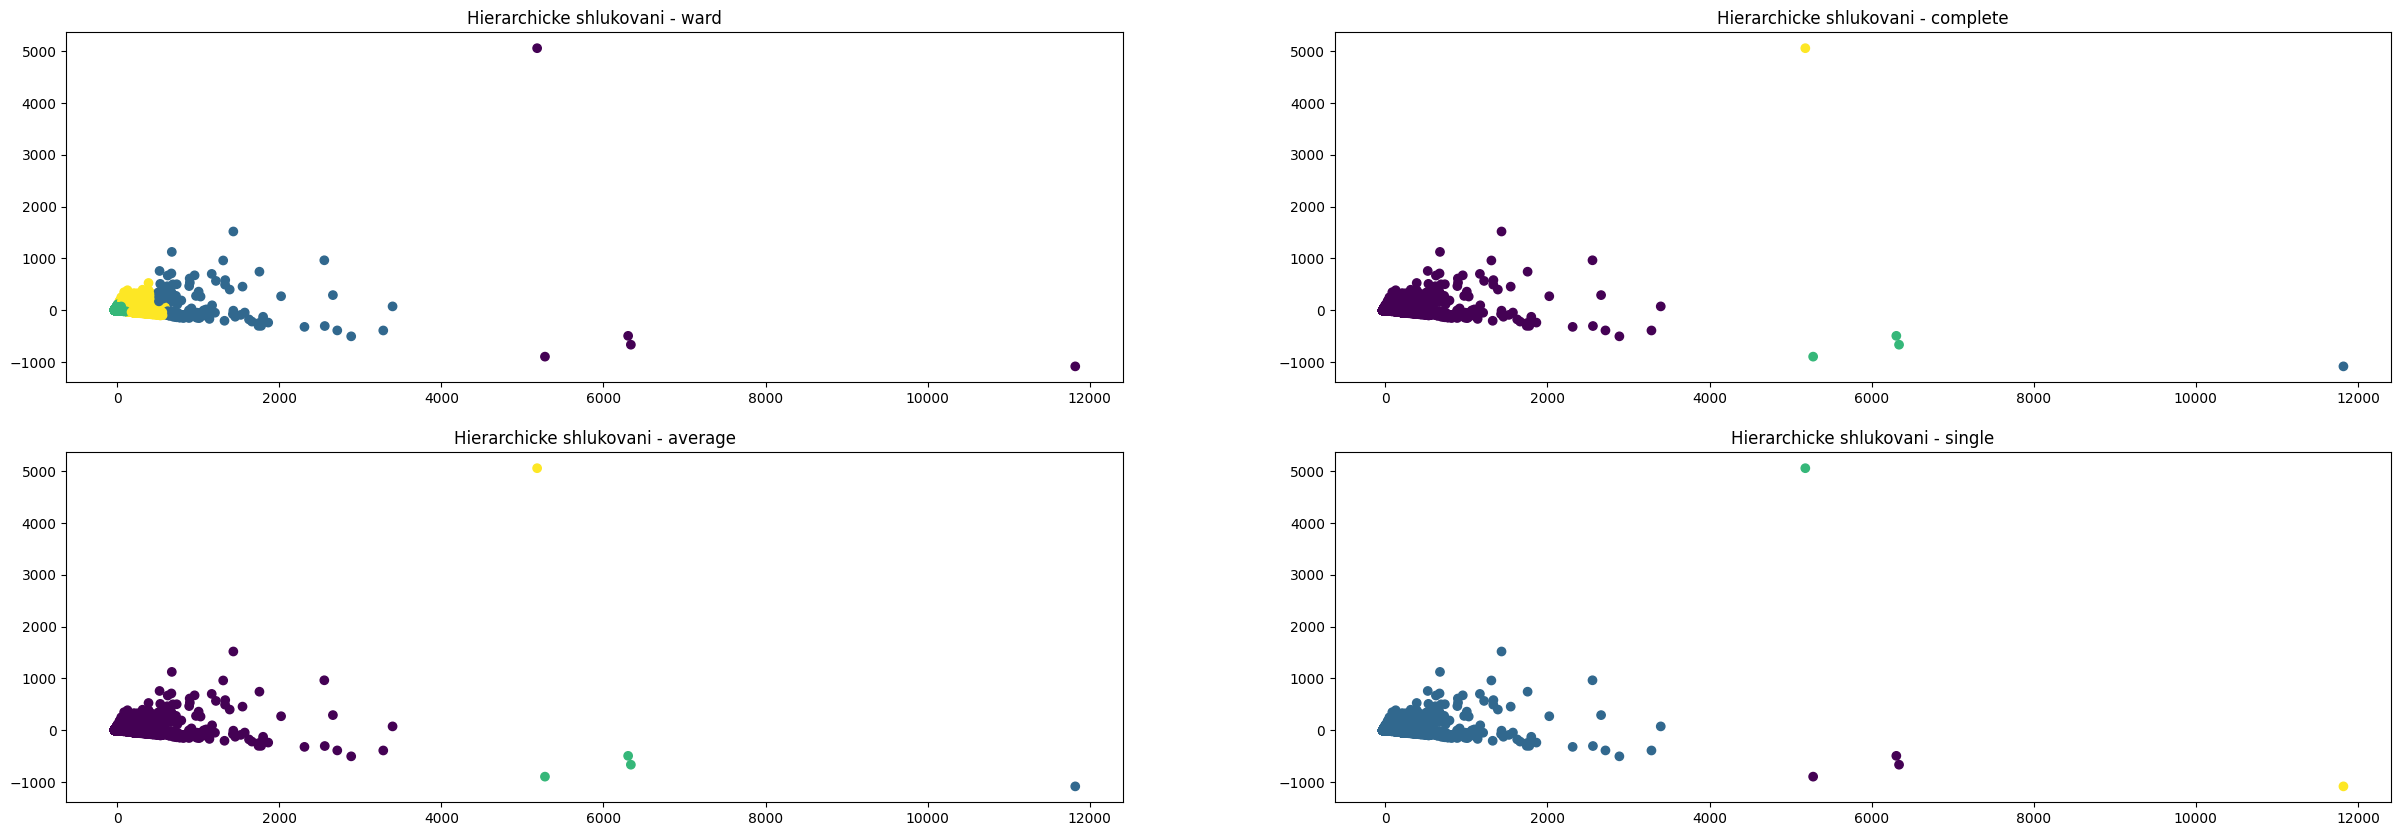

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
# https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
# Pro kazdy dataset provedu 4 ruzne zpusoby hierarchickeho shlukovani, vzdy s 4 clustery
for i in range(len(datasets)):
    
    fig, ax = plt.subplots(2, 2, figsize = (30,10))

    # Odzkousim tyto 4 parametry
    methods = ["ward", "complete", "average", "single"]
    method_index = 0
    best_labels_measurement = 1
    best_labels = None
    for j in range(2):
        for k in range(2):
            method = methods[method_index]
            hierarchical_clustering = AgglomerativeClustering(n_clusters=4, linkage=method)
            hierarchical_clustering.fit(datasets[i])
        
            labels = hierarchical_clustering.labels_
        
            ax[j][k].scatter(datasets[i][:, 0], datasets[i][:, 1], c=labels)
            ax[j][k].set_title("Hierarchicke shlukovani - " + method)
            method_index += 1
            
            # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html
            # Cim blize je cislo k 0, tim kvalitnejsi clustery jsou
            dbi = davies_bouldin_score(datasets[i], labels)

            if dbi < best_labels_measurement and method != "single" and method != "average" and method != "complete":
                best_labels_measurement = dbi
                best_labels = labels
            
            print("Davies-Bouldin index pro dataset " + str(i) + " a metodu " + method + ":", dbi)

    # Prirazeni podle nejlepsi metody
    datasets_save[i]["CLUSTER"] = best_labels
        
    plt.show()


### Počet clusterů
- Pro všechny datasety byly spuštěny 4 různé metody hierarchického shlukování -- parametry **ward**, **complete**, **average**, **single**.
- Experimentálně bylo ověřeno, že nejvhodnější počet clusterů je buď 4 nebo 6 (na základe nejnižších přítomných Davies-Bouldin indexů).


### Výsledky hierarchiuckého shlukování a problémy overfittingu
- Problém s 6 clustery je, že DBI vyšlo až příliš nízké, v řádech tisícin s datasetem 0 a metodou **single**. To může značit přetrénování a proto byl zvolen počet clusterů 4, který stále udává solidní výsledky.
- Všechny metody (nejméně problematická je z tohoto pohledu metoda *ward*) vykazují známky overfittingu, protože ve 3 clusterech jsou pouhé jednotky, maximální nižší desítky, hodnot.
- V případě Youtube datasetu jsou všechny metody krom Ward totožné.
- Proto budou všechny metody krom Ward ignorovány, nicméně vizualizace jsou k dispozici výše.
- V případě 4 clusterů a akceptace pouze metody ward má nejlepší výsledek dataset 2 (viz [sekce](#datasets_explained)) -- DBI je **0.350**.
- Výsledek je lepší než u K-Means a čistě na základě DBI je možné konstatovat, že clustering byl úspěšnější.
- Pro Youtube dataset je výsledek naopak horší.

### Odpovídající TLS_SNI
Dále se opět zaměříme na nejlepší získané výsledky. Opět bude prozkoumáno 10 nejčastějích adres TLS_SNI, které k jednotlivým shlukům patří.

Poté proběhne opět analýza výsledků Youtube datasetu.

CLUSTER
0    12728
3       64
1       16
2        1
Name: count, dtype: int64


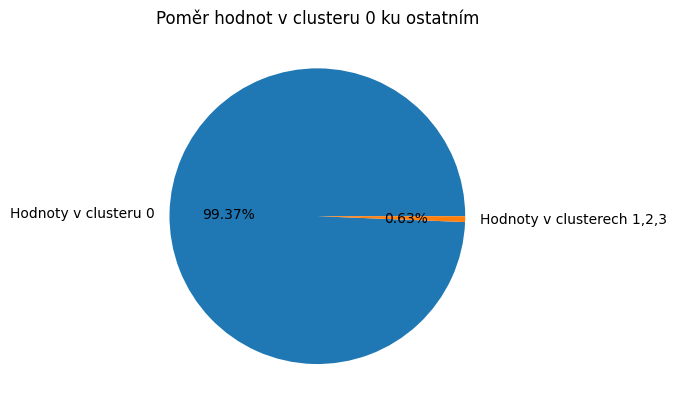

In [13]:
# Navrat puvodnich TLS_SNI hodnot pro dataset 0
df = datasets_save[2]
df["TLS_SNI"] = shorter_tls_labels[2]

print(df["CLUSTER"].value_counts())

n_of_zero_cl = df["CLUSTER"].value_counts().nlargest(1).sum()
rest = df["CLUSTER"].value_counts().sum() - n_of_zero_cl

fig, ax = plt.subplots()
ax.pie([n_of_zero_cl, rest], labels=["Hodnoty v clusteru 0", "Hodnoty v clusterech 1,2,3"], autopct='%1.2f%%');
ax.set_title("Poměr hodnot v clusteru 0 ku ostatním");

- 99.37% všech hodnot patří do jediného clusteru, což je ještě horší než v případě K-Means.
- Davies-Bouldin index ovšem vychází nižší, tedy lepší.
- Výsledek však stále není uspokojivý.

In [14]:
cluster_counts_tls = df.groupby("CLUSTER")["TLS_SNI"].value_counts()
cluster_counts_tls.groupby("CLUSTER").nlargest(10)

CLUSTER  CLUSTER  TLS_SNI                          
0        0        www.google.com                       789
                  fonts.gstatic.com                    295
                  dns.google                           278
                  doh.opendns.com                      269
                  play.googleapis.com                  265
                  www.youtube.com                      235
                  safebrowsing.googleapis.com          227
                  www.googleapis.com                   224
                  www.gstatic.com                      216
                  googleads.g.doubleclick.net          209
1        1        cz-bks400-prod15-live.solocoo.tv       2
                  ce-eu.wgcdn.co                         1
                  fonts.gstatic.com                      1
                  ivys-vst17-5.o2tv.cz                   1
                  ivys-vst18-5.o2tv.cz                   1
                  live-ak.vimeocdn.com                   1
    

- V clusteru 2 a 1 se opět často vyskytují služby související se streamingem videa.
- To však nepotvrzuje, že by služby využívaly více typů toků, pouze se "povedlo" služby rozřadit podle jejich vlastností.
- Výsledky však nejsou dobré, v clusterech 1, 2 a 3 je málo hodnot.

<a id="youtube-hier"></a>
### Youtube dataset s hierarchickým shlukováním

Opět si znovu vizualizujeme výsledek shlukování

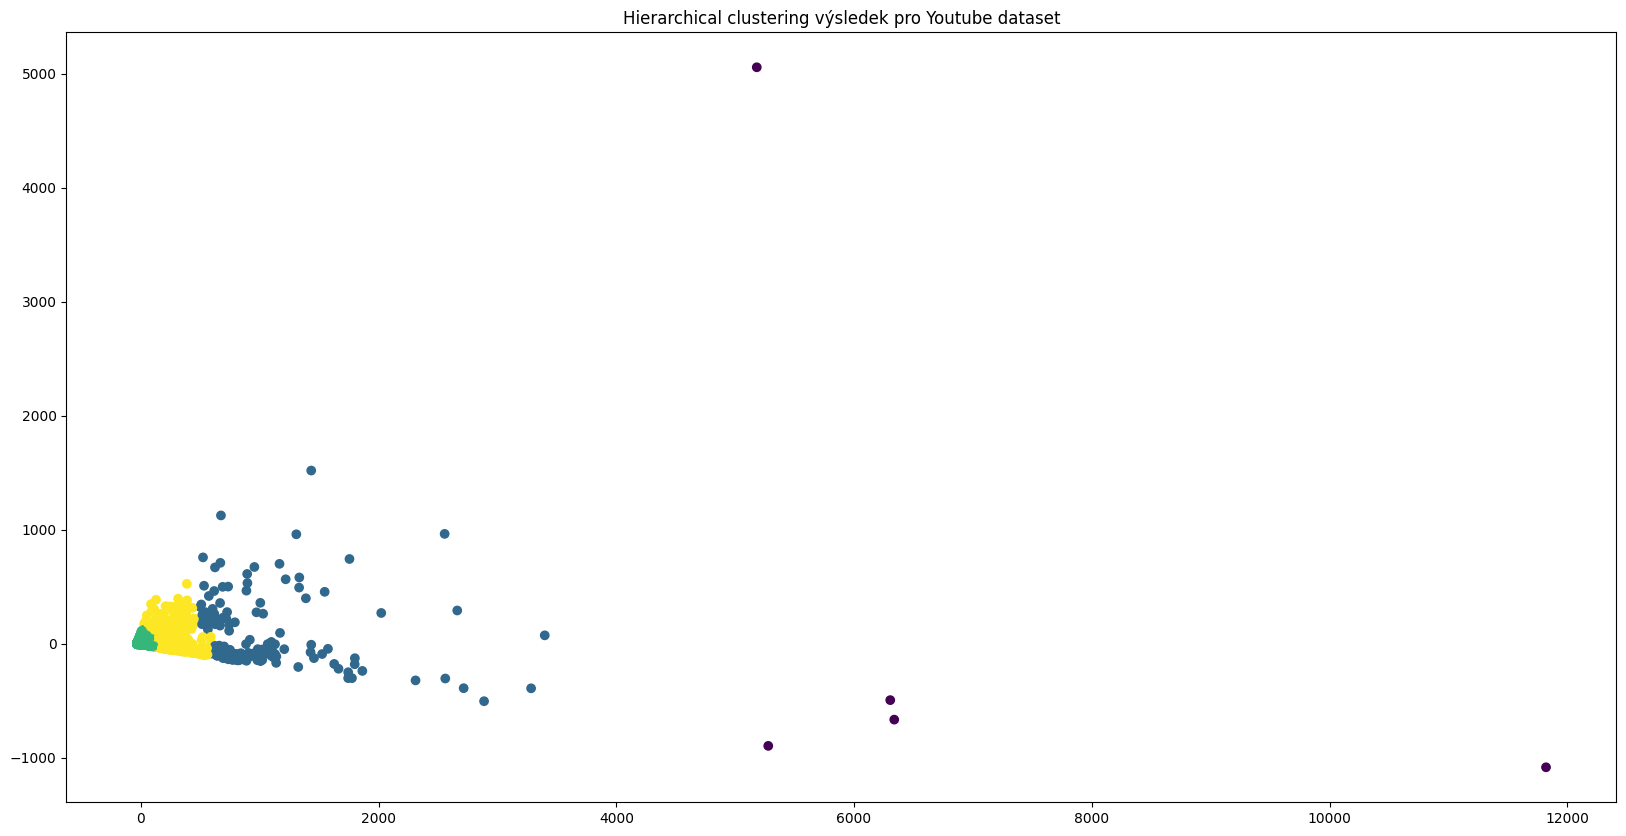

CLUSTER
2    21119
3     1445
1      159
0        5
Name: count, dtype: int64


In [15]:
df_hierarchy = datasets_save[5]

hierarchical_clustering = AgglomerativeClustering(n_clusters=4)
hierarchical_clustering.fit(datasets[5])
    
plt.figure(figsize = (20,10))
plt.scatter(datasets[5][:, 0], datasets[5][:, 1], c=hierarchical_clustering.labels_)
plt.title('Hierarchical clustering výsledek pro Youtube dataset')
plt.show()

# Nactu si hodnoty z puvodniho datasetu, ale pouze ty odpovidajici tokum s Youtube
df_hierarchy = original_df[original_df.index.isin(df_hierarchy.index)].copy(deep=True)

# Priradim ziskane clustery
df_hierarchy["CLUSTER"] = hierarchical_clustering.labels_

print(df_hierarchy["CLUSTER"].value_counts())
cluster_counts_tls = df_hierarchy.groupby("CLUSTER").value_counts()


Výsledek je podobný K-Means. To potvrzují i počty hodnot v clusterech, které jsou opět podobné výsledkům K-means. Vyjímkou je cluster 0, který obsahuje pouhých 5 hodnot -- ty nebudou brány v potaz. Opět si zobrazíme průměry:

In [16]:
df_hierarchy = df_hierarchy[df_hierarchy["CLUSTER"].isin([1,3, 2])]
df_hierarchy_stats = print_cluster_stats(df_hierarchy)

Prumerny pocet paketu klient->server
 CLUSTER
2      25.123917
3     343.737024
1    1767.276730
Name: PACKETS, dtype: float64
Prumerny pocet paketu server->klient
 CLUSTER
2      31.724419
3     848.329412
1    3774.000000
Name: PACKETS_REV, dtype: float64
Prumerna velikost toku v bytechve smeru  klient->server
 CLUSTER
2      7627.091624
3     78086.902422
1    721646.698113
Name: BYTES, dtype: float64
Prumerna velikost toku v bytech ve smeru server->klient
 CLUSTER
2    1.840869e+04
3    1.023254e+06
1    3.561393e+06
Name: BYTES_REV, dtype: float64
Prumerna delka trvani toku v sekundach
 CLUSTER
2     26.670818
3    143.338408
1    802.981132
Name: TIME, dtype: float64


### Statistiky Youtube datasetu získané přes Hierarchické shlukování
Statistiky potvrzují, že cluster s největším množstvím hodnot je ten, kde jsou všechny průměry oproti ostatním clusterům nejnižší. Průměry se však oproti těm, které byly vypočítány přes K-Means v předchozí [sekci](#k-means-youtube), odlišují. 
')

## DBSCAN shlukování
Třetím a posledním shlukovacím algoritmem bude [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) algoritmus. Na základě pozorovaných rozložení hodnot bude minimální počet vzorků v clusteru nastaven na 5.

Jako metrika vyhodnocení tentokrát nebude použit DB Index, ale [Silhuette Score](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Čím blíže je hodnota k 1, tím kvalitnější výsledek. Nejhorsší výsledek je -1.

Silhuette score pro dataset 0: 0.5872200898386144


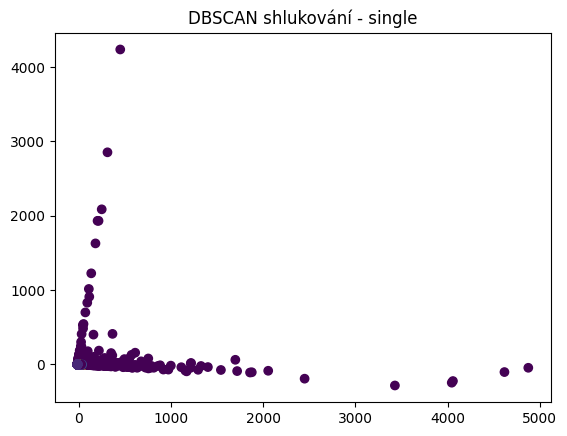

Silhuette score pro dataset 1: 0.6181075084505796


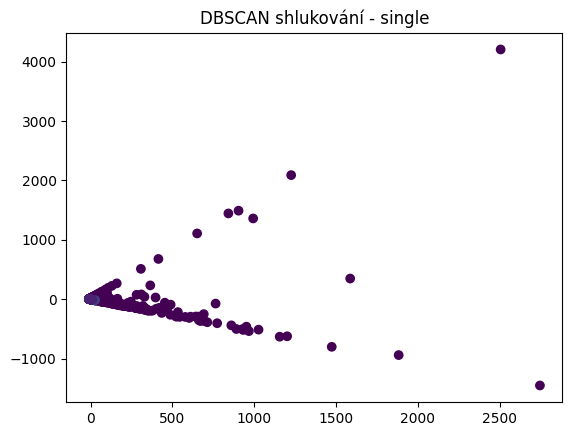

Silhuette score pro dataset 2: 0.6324332473969588


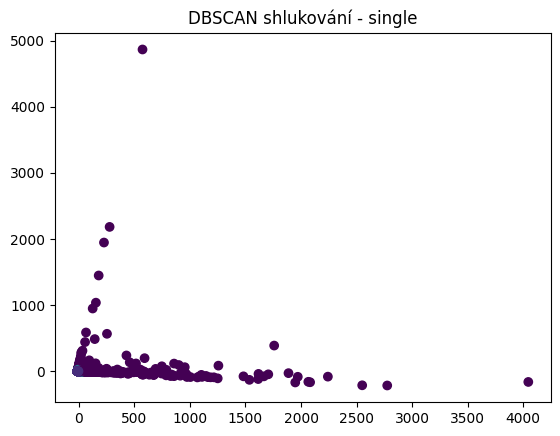

Silhuette score pro dataset 3: 0.6081879571874471


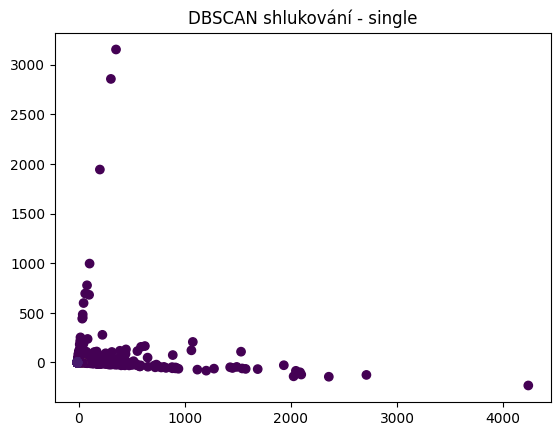

Silhuette score pro dataset 4: 0.6429409944900769


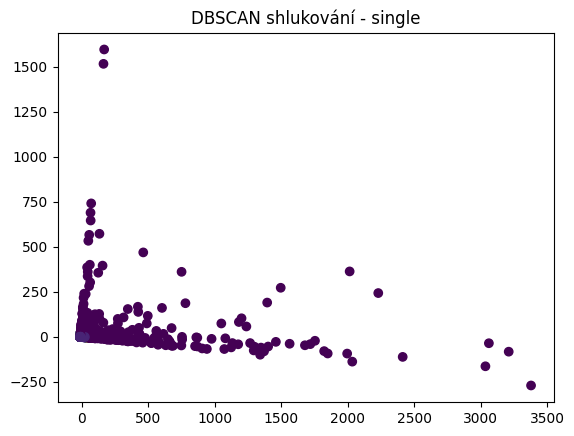

Silhuette score pro dataset 5: 0.5898217971013022


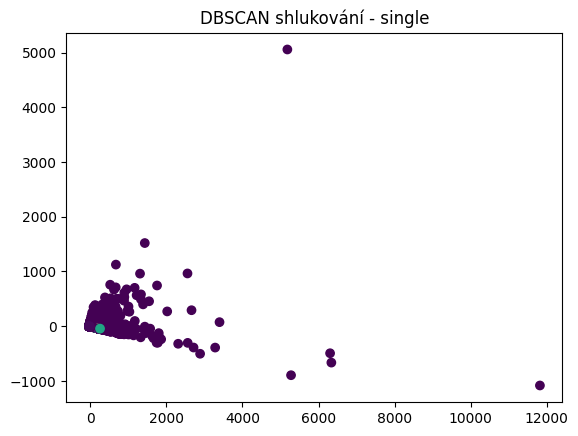

In [17]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
# Pro vsechny datatsety se provede OPTICS metoda
for i in range(len(datasets)):

    fig, ax = plt.subplots()
    dbscan_clustering = DBSCAN(eps=1, min_samples=5)
    dbscan_clustering.fit(datasets[i])
        
    labels = dbscan_clustering.labels_
        
    ax.scatter(datasets[i][:, 0], datasets[i][:, 1], c=labels)
    ax.set_title("DBSCAN shlukování - " + method)
            
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
    # Cim blize je cislo k 1, tim kvalitnejsi clustery jsou. 0 znaci prolinajici se clustery. -1 znaci nekvalitni vysledek.
    silhouette = silhouette_score(datasets[i], labels)
    
    print("Silhuette score pro dataset " + str(i) + ":", silhouette)

    # Prirazeni podle nejlepsi metody
    datasets_save[i]["CLUSTER"] = labels
        
    plt.show()

- Je patrné, že nejlepší výsledky jsou podle Silhuette score metriky pro dataset 4 a to **0.643**.
- Na ten se dále zaměříme
- Zaměříme se pouze na clustery 0, -1 a 2, které obsahují alespoň 20 hodnot.

CLUSTER
 0    11911
-1      655
 2       20
 3       11
 8        9
 5        7
 7        7
 1        6
 4        6
 9        5
 6        5
Name: count, dtype: int64


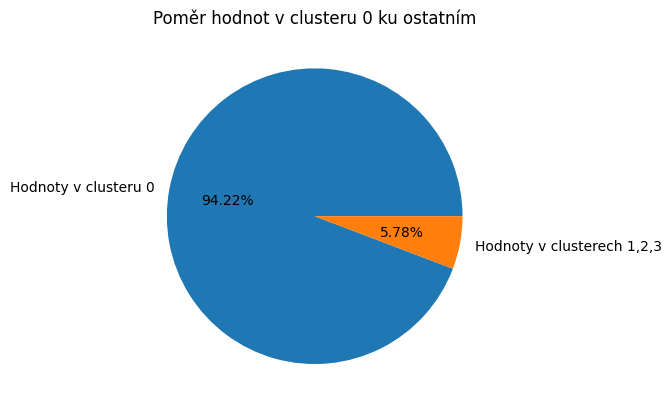

In [23]:
df = datasets_save[4]
print(df["CLUSTER"].value_counts())

n_of_zero_cl = df["CLUSTER"].value_counts().nlargest(1).sum()
rest = df["CLUSTER"].value_counts().sum() - n_of_zero_cl

fig, ax = plt.subplots()
ax.pie([n_of_zero_cl, rest], labels=["Hodnoty v clusteru 0", "Hodnoty v clusterech 1,2,3"], autopct='%1.2f%%');
ax.set_title("Poměr hodnot v clusteru 0 ku ostatním");

# Odstraneni clusteru krom 0, -1, 2
df = df[df["CLUSTER"].isin([0, -1, 2])].copy(deep=True)

In [19]:
df["TLS_SNI"] = shorter_tls_labels[4]
cluster_counts_tls = df.groupby("CLUSTER")["TLS_SNI"].value_counts()


print(cluster_counts_tls.groupby("CLUSTER").nlargest(10).to_string())

CLUSTER  CLUSTER  TLS_SNI                       
-1       -1       www.google.com                     37
                  mail.google.com                    33
                  www.googletagmanager.com           23
                  ms4.applovin.com                   23
                  www.youtube.com                    22
                  play.google.com                    16
                  i.ytimg.com                        15
                  www.gstatic.com                    12
                  securepubads.g.doubleclick.net     12
                  inbox.google.com                   11
 0        0       www.google.com                    659
                  doh.opendns.com                   304
                  dns.google                        281
                  fonts.gstatic.com                 268
                  play.googleapis.com               237
                  www.youtube.com                   212
                  safebrowsing.googleapis.com       212

- Ačkoliv to není z vizualizace na první pohled zjevné, dataset byl rozdělen na mnoho clusterů. 
- Rozdíl oproti K-means i Hierarchickému shlukování je zde vidět v tom, že relativně vysoký počet hodnot je i mimo hlavní cluster.
- V hlavním clusteru je "pouze" **94.22%** hodnot.
- Napříč všemu 3 hlavními clustery se ovšem tentokrát neobjevuje očekáváný streaming dat, ale různé google služby.
- Ve všech clusterech jsou skoro stejné služby, což by mohlo znamenat, že tyto služby využívají více toků, které jsou si navzájem podobné. Výsledek se však liší od předchozích algoritmů.


### Youtube cluster s DBSCAN
Nyní se zaměříme na Youtube cluster.

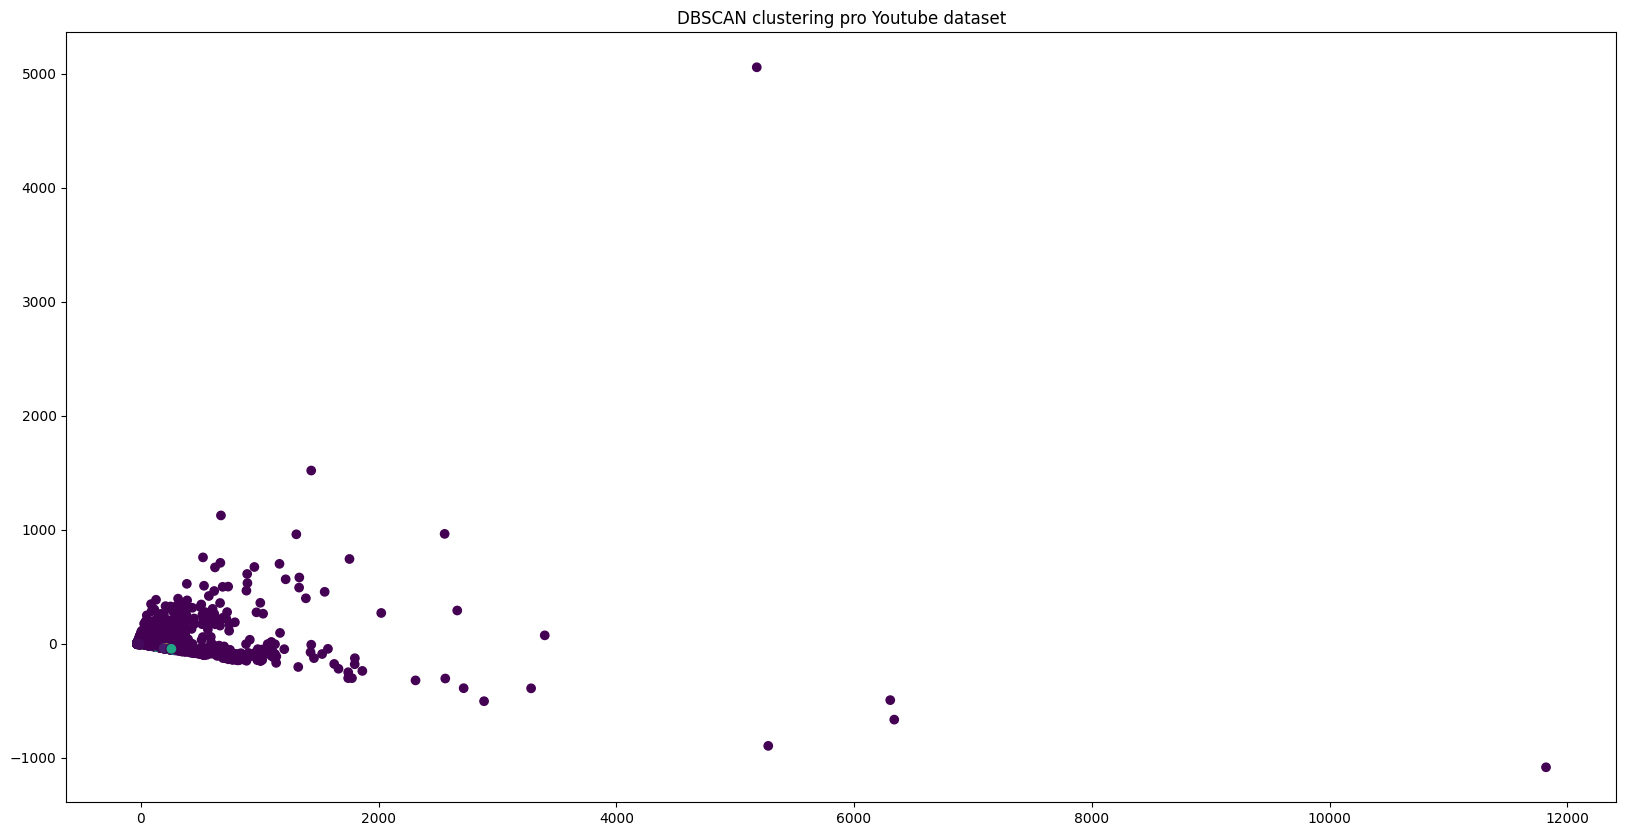

CLUSTER
 0     20130
-1      2011
 3       128
 17       37
 11       30
 8        29
 5        28
 20       19
 10       15
 1        15
 24       13
 19       12
 16       11
 26       11
 35       10
 22       10
 2         9
 38        9
 6         9
 15        9
 12        8
 14        8
 45        8
 33        8
 7         8
 39        8
 29        7
 23        7
 28        7
 27        7
 25        6
 42        6
 37        6
 31        6
 40        6
 43        6
 9         6
 21        5
 18        5
 41        5
 48        5
 13        5
 30        5
 44        5
 34        5
 47        5
 46        5
 36        5
 4         5
 32        5
Name: count, dtype: int64


In [20]:
df_dbscan = datasets_save[5]

dbscan_clustering = DBSCAN(eps=1, min_samples=5)
dbscan_clustering.fit(datasets[5])
        
labels = dbscan_clustering.labels_
    
plt.figure(figsize = (20,10))
plt.scatter(datasets[5][:, 0], datasets[5][:, 1], c=labels)
plt.title('DBSCAN clustering pro Youtube dataset')
plt.show()

# Nactu si hodnoty z puvodniho datasetu, ale pouze ty odpovidajici tokum s Youtube
df_dbscan = original_df[original_df.index.isin(df_dbscan.index)].copy(deep=True)

# Priradim ziskane clustery
df_dbscan["CLUSTER"] = labels

print(df_dbscan["CLUSTER"].value_counts())
cluster_counts_tls = df_dbscan.groupby("CLUSTER").value_counts()



- Počty hodnot napříč clustery se oproti předchozím algoritmům liší. Clusterů DBSCAN také vygeneroval daleko více.
- Ve druhém největším clusteru je daleko více hodnot, než v předchozích případech. Zároveň i ve třetím. největším clusteru je hodnot více.
- Tři největší clustery jsou 0, -1 a 3, budeme se zabývat jen nimi, aby byly výsledky v souladu s ostatními Youtube dataset analýzami.

In [21]:
# Necham si pouze nejvetsi clustery
df_dbscan = df_dbscan[df_dbscan["CLUSTER"].isin([0, -1, 3])].copy(deep=True)
df_dbscan_stats = print_cluster_stats(df_dbscan)

Prumerny pocet paketu klient->server
 CLUSTER
 0     18.395380
 3    129.992188
-1    455.293884
Name: PACKETS, dtype: float64
Prumerny pocet paketu server->klient
 CLUSTER
 0     20.937457
 3    603.789062
-1    946.005470
Name: PACKETS_REV, dtype: float64
Prumerna velikost toku v bytechve smeru  klient->server
 CLUSTER
 0      4439.455390
 3      6178.515625
-1    155624.689707
Name: BYTES, dtype: float64
Prumerna velikost toku v bytech ve smeru server->klient
 CLUSTER
 0     11426.610035
 3    856164.421875
-1    954174.168076
Name: BYTES_REV, dtype: float64
Prumerna delka trvani toku v sekundach
 CLUSTER
 3      0.109375
 0     19.894039
-1    234.024863
Name: TIME, dtype: float64


- Z výsledků je patrné, že tentokrát je skladba clusterů v Youtube datasetu jiná než v minulých případech (viz sekce [K-Means](#youtube-k-means) a [Hierarchické shlukování](#youtube-hier)).
- Hodnoty jsou o mnoho nižší než u předchozích algoritmů.
- V další sekci porovnáme získané statistiky pro Youtube dataset napříč všemi algoritmy.

## Vyhodnocení Youtube clusterů
- Názvy clusterů se sice v obou výsledcích liší, nicméně průměry z jednotlivých clusterů byly seřazeny od největšího po nejmenší a mohou tedy být porovnávány.
- Nové clustery se označují jako 0, 1 a 2. Odpovídají poměrově u K-means clusterům 0, 1, 3 v tomto pořadí.
- U Hierarchického shlukování odpovídají clustery 0, 1, 2 clusterům 2, 3, 1 v tomto pořadí.
- DBSCAN pak nové clustery 0, 1 a 2 odpovídají clusterům 0, -1 a 3 v tomto pořadí.

Rozdíly si graficky vizualizujeme:

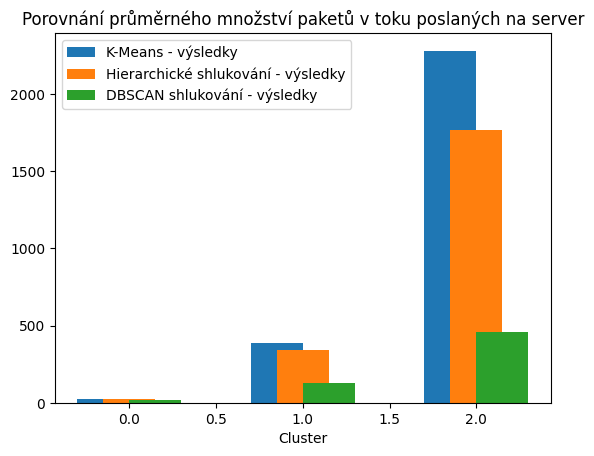

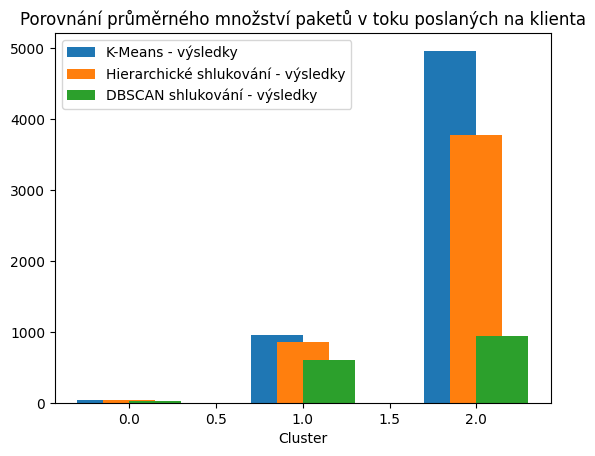

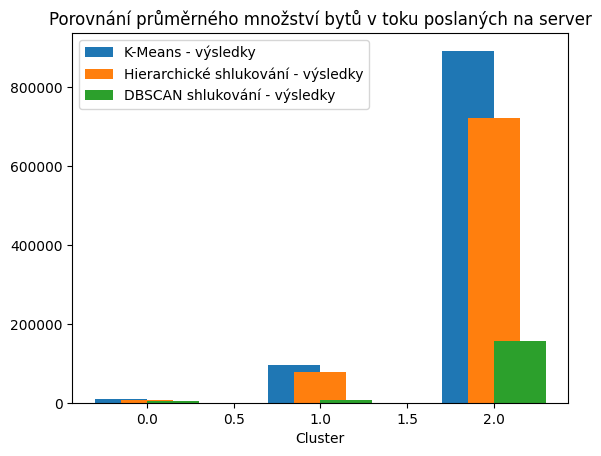

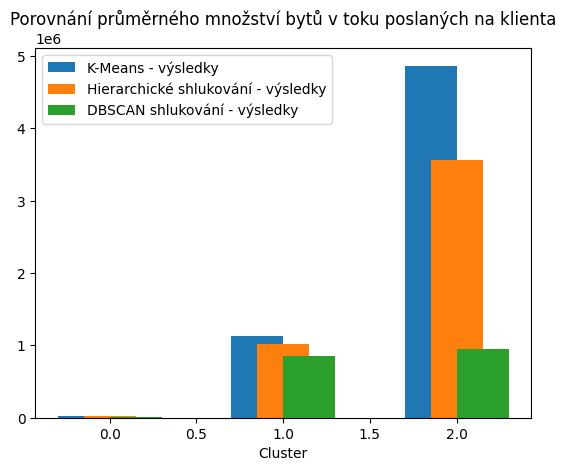

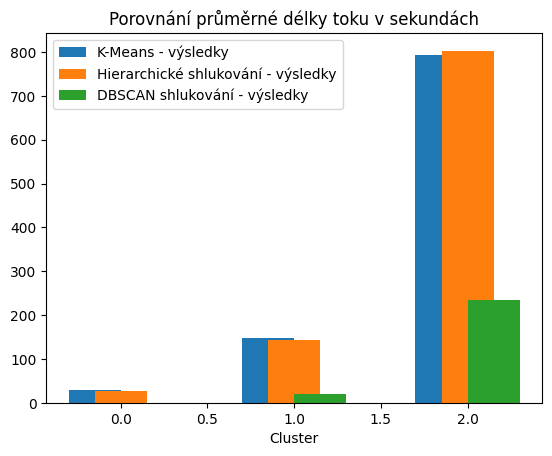

In [22]:
# Funkce pro vykresleni porovnani vysledku
def visualize_statistic(df_stats, df_hierarchy_stats, df_dbscan_stats, title):
    fig, ax = plt.subplots()
    x = numpy.arange(3)
    width = 0.30
    ax.bar(x - width/2, df_stats, width, label='K-Means - výsledky')
    ax.bar(x, df_hierarchy_stats, width, label='Hierarchické shlukování - výsledky')
    ax.bar(x + width/2, df_dbscan_stats, width, label='DBSCAN shlukování - výsledky')
    ax.set_xlabel('Cluster')
    ax.legend()
    ax.set_title(title);

visualize_statistic(df_stats[0], df_hierarchy_stats[0], df_dbscan_stats[0], "Porovnání průměrného množství paketů v toku poslaných na server")
visualize_statistic(df_stats[1], df_hierarchy_stats[1], df_dbscan_stats[1], "Porovnání průměrného množství paketů v toku poslaných na klienta")
visualize_statistic(df_stats[2], df_hierarchy_stats[2], df_dbscan_stats[2], "Porovnání průměrného množství bytů v toku poslaných na server")
visualize_statistic(df_stats[3], df_hierarchy_stats[3], df_dbscan_stats[3], "Porovnání průměrného množství bytů v toku poslaných na klienta")
visualize_statistic(df_stats[4], df_hierarchy_stats[4], df_dbscan_stats[4], "Porovnání průměrné délky toku v sekundách")


- Z vzniklých grafů lze pozorovat, že v prvních dvou případech clusterování jsou si průměry atributů relativně podobné.
- DBSCAN se však oproti předchozím liší a to tím, že má ve všech případech průměry nižší.

## Odpovědi na otázky ze zadání
Veškeré informace vychází z dat popsaných tady v notebooku a z části i při experimentech, které zde nejsou uvedeny pro svou nezajímavost. Celkově byla shluková analýza relativně málo úspěšná, neboť se nepodařilo data rozdělit na dostatečně velké shluky -- většina dat vždy zůstává jen v jednom shluku. Je možné, že jsou si natolik podobné, že to jinak nešlo, ovšem v kontextu zadání se to zdá být nepravděpodobné a problém bude někde jinde. 

Vyjímkou je Youtube dataset, u nějž je kvalita clusteringu udávána DB Indexem velmi nízká, ale hodnoty jsou tentokrát více rozděleny mezi jednotlivé clustery. Hodnoty atributů v těchto clusterech se pak velmi odlišují.

### a) Toky s kterými TLS SNI byly shlukovány společně?
Výsledky shlukování byly poněkud neuspokojivé, avšak oba algoritmy odhalily clustery, které obsahují velké množství dat týkající se pravděpodobně přenosu videa (solocoo.tv, youtube.com. googlevideo.com...).

### b) Byli jste schopni nalézt shluky odpovídající přenosu videa, souborů, metadat?
Tato informace bohužel z datasetů 0-4 dostupná není. Na základě výsledků shlukování je možno konstatovat, že se pravděpodobně toky ke konkrétním serverům děli na více typů (metadata, videa...), ovšem přesné rozdělení nebylo nalezeno.

V případě Youtube datasetu (dataset zaměřený pouze na službu Youtube.com) byly výsledky lepší a bylo možné rozpoznat toky, které se navzájem liší hlavně v délce a tedy i v počtu přenesených bytů a paketů. To lze považovat za potvrzení, že konkrétně pro službu Youtube se toky mezi sebou liší, pravděpodobně právě na základu přenášené informace.

### b) Podle kterých statistických informací se toky dobře shlukují?Toky se shlukují primárně podle numerických hodnot, konkrétně pak množství přenesených paketů, bytů a v některých datasetech i čas přenosu nebo TCP vlajky. Experimentálně se ukázalo, že všechny atributy, které jsou v datasetu přítomné, jsou schopny po jejich odstranění výsledky shlukování poměrně silně ovlivnit.

### b) Jaké jsou podskupiny toků, které by bylo možné rozlišit?
Podařilo se rozlišit toky spadající pod služby nabízející streamování videa. Ovšem jen ve velmi omezené míře.

V případě Youtube datasetu se povedlo rozlišit toky, které se odlišují délkou trvání a počtem přenesených bytů/paketů.

